# Few shot learning pour la classification de signaux


In [1]:
import numpy as np
import torch
import h5py # pour gérer les formats de données utilisés ici
import matplotlib.pyplot as plt
import os
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics.classification import MulticlassConfusionMatrix
import math

np.random.seed(24)

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Used device : {device}")

Used device : cuda:0


## Data vizualisation

In [3]:
# Import des données

def get_labels(open_h5_file):
    return {
        open_h5_file['label_name'].attrs[k] : k
        for k in open_h5_file['label_name'].attrs.keys()
    }

train_path = 'train.hdf5' # contient les classes 0 à 6
validation_path = 'validation.hdf5' # contient les classes 0 à 6

sample_path = 'endroll.hdf5' # contient un nombre réduits de signaux des classes 6 à 11
test_path = 'test_fewshot.hdf5'  # test contenant des signaux des classes 6 à 11


train = h5py.File(train_path , 'r')
sample = h5py.File(sample_path, 'r')
test = h5py.File(test_path, 'r')
val  =  h5py.File(validation_path, 'r')

signals_train = np.array(train['signaux'])
snr_train =  np.array(train['snr'])
labels_id_train = np.array(train['labels'])

signals_sample = np.array(sample['signaux'])
snr_sample =  np.array(sample['snr'])
labels_id_sample = np.array(sample['labels'])

signals_val = np.array(val['signaux'])
snr_val =  np.array(val['snr'])
labels_id_val = np.array(val['labels'])

signals_test = np.array(test['signaux'])
snr_test =  np.array(test['snr'])
labels_id_test = np.array(test['labels'])

sample.close()
train.close()
val.close()
test.close()

### Affichage du nombre de sample par classes par label par SNR

In [4]:
for id in range(12):
  if id < 6: # labels du train
    print(f'amount of data for label = {id} : {np.where(labels_id_train==id)[0].shape}')
  else:
    print(f"amount of data for label = {id} : {np.where(labels_id_sample==id)[0].shape}")

print("----------------------------------------------")
for snr in [0, 10, 20, 30]:
    for id_ in range(12):
      if id_ < 6 :
        mask = (snr_train == snr) & (labels_id_train == id_)
        count = mask.sum()
        print(f"Amount of data for snr = {snr} and label = {id_}: {count}")
      else:
        mask = (snr_sample == snr) & (labels_id_sample == id_)
        count = mask.sum()
        print(f"Amount of data for snr = {snr} and label = {id_}: {count}")


amount of data for label = 0 : (5143,)
amount of data for label = 1 : (4968,)
amount of data for label = 2 : (5053,)
amount of data for label = 3 : (4867,)
amount of data for label = 4 : (4894,)
amount of data for label = 5 : (5075,)
amount of data for label = 6 : (93,)
amount of data for label = 7 : (99,)
amount of data for label = 8 : (78,)
amount of data for label = 9 : (66,)
amount of data for label = 10 : (75,)
amount of data for label = 11 : (89,)
----------------------------------------------
Amount of data for snr = 0 and label = 0: 1318
Amount of data for snr = 0 and label = 1: 1219
Amount of data for snr = 0 and label = 2: 1282
Amount of data for snr = 0 and label = 3: 1247
Amount of data for snr = 0 and label = 4: 1274
Amount of data for snr = 0 and label = 5: 1320
Amount of data for snr = 0 and label = 6: 0
Amount of data for snr = 0 and label = 7: 0
Amount of data for snr = 0 and label = 8: 0
Amount of data for snr = 0 and label = 9: 0
Amount of data for snr = 0 and label 

### Plot IQ constellations

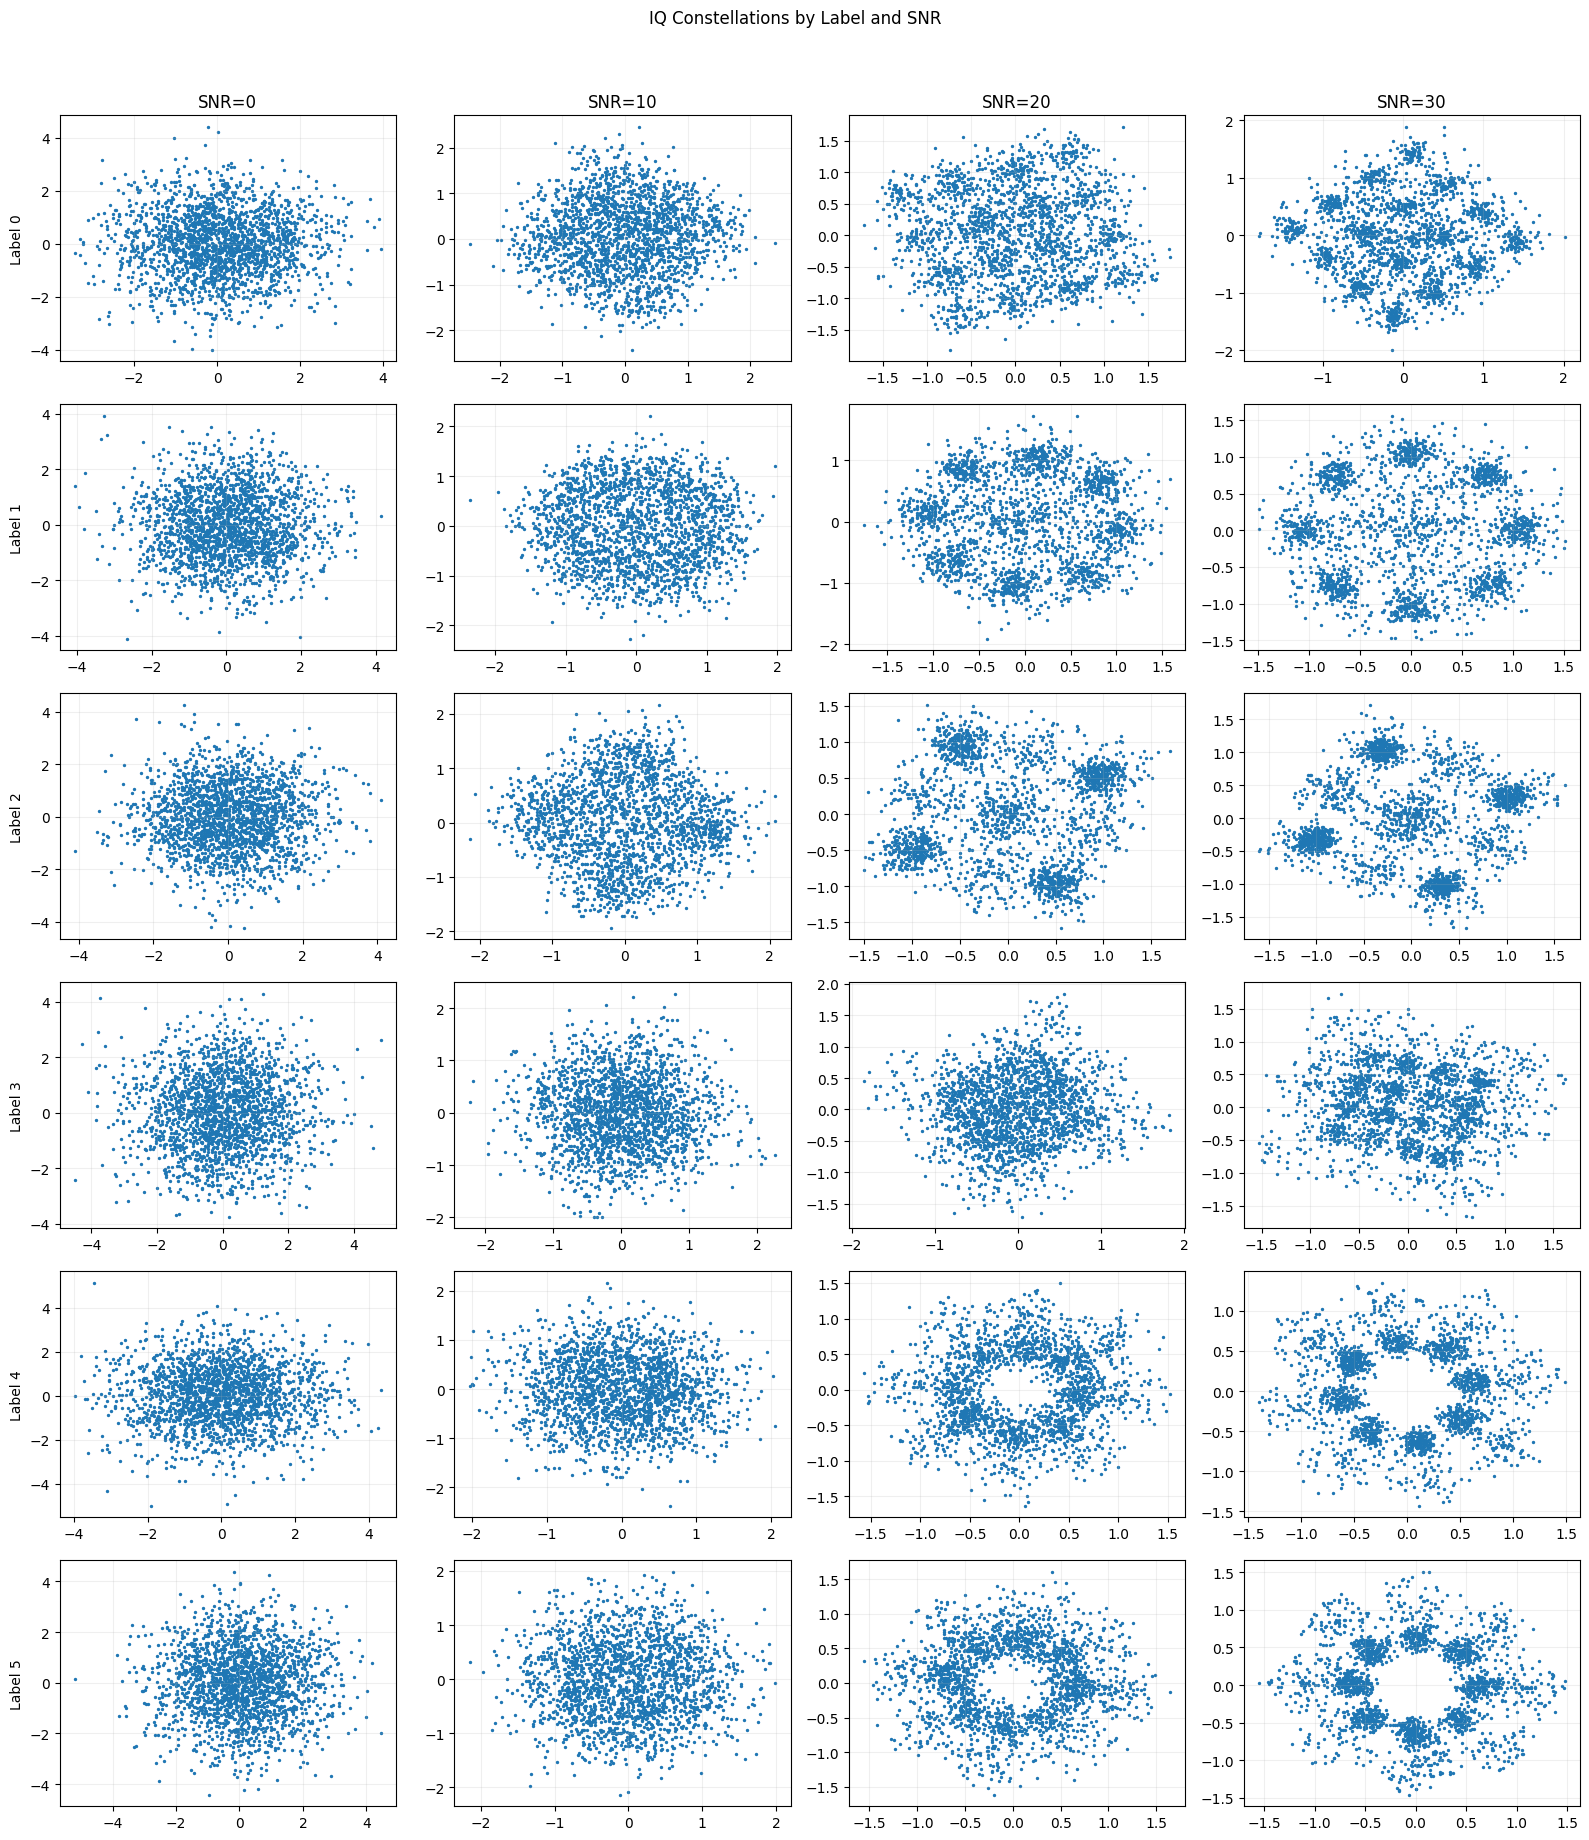

In [5]:
snr_values_train = [0, 10, 20, 30]
labels = [0,1,2,3,4,5]

fig, axes = plt.subplots(
    nrows=len(labels),
    ncols=len(snr_values_train),
    figsize=(4 * len(snr_values_train), 3 * len(labels)),

)

for i, lbl in enumerate(labels):
    for j, snr in enumerate(snr_values_train):
        ax = axes[i, j]

        # indices for this (label, snr)
        mask = (labels_id_train == lbl) & (snr_train == snr)
        idx = np.where(mask)[0]

        if len(idx) == 0:
            ax.set_axis_off()
            continue

        sig = signals_train[idx[0]]          # shape (2048, 2)
        I = sig[:, 0]
        Q = sig[:, 1]

        ax.scatter(I, Q, s=2)
        ax.grid(alpha=0.2)

        if i == 0:
            ax.set_title(f"SNR={snr}")
        if j == 0:
            ax.set_ylabel(f"Label {lbl}")

fig.suptitle("IQ Constellations by Label and SNR", y=1.02)
plt.tight_layout()
plt.show()


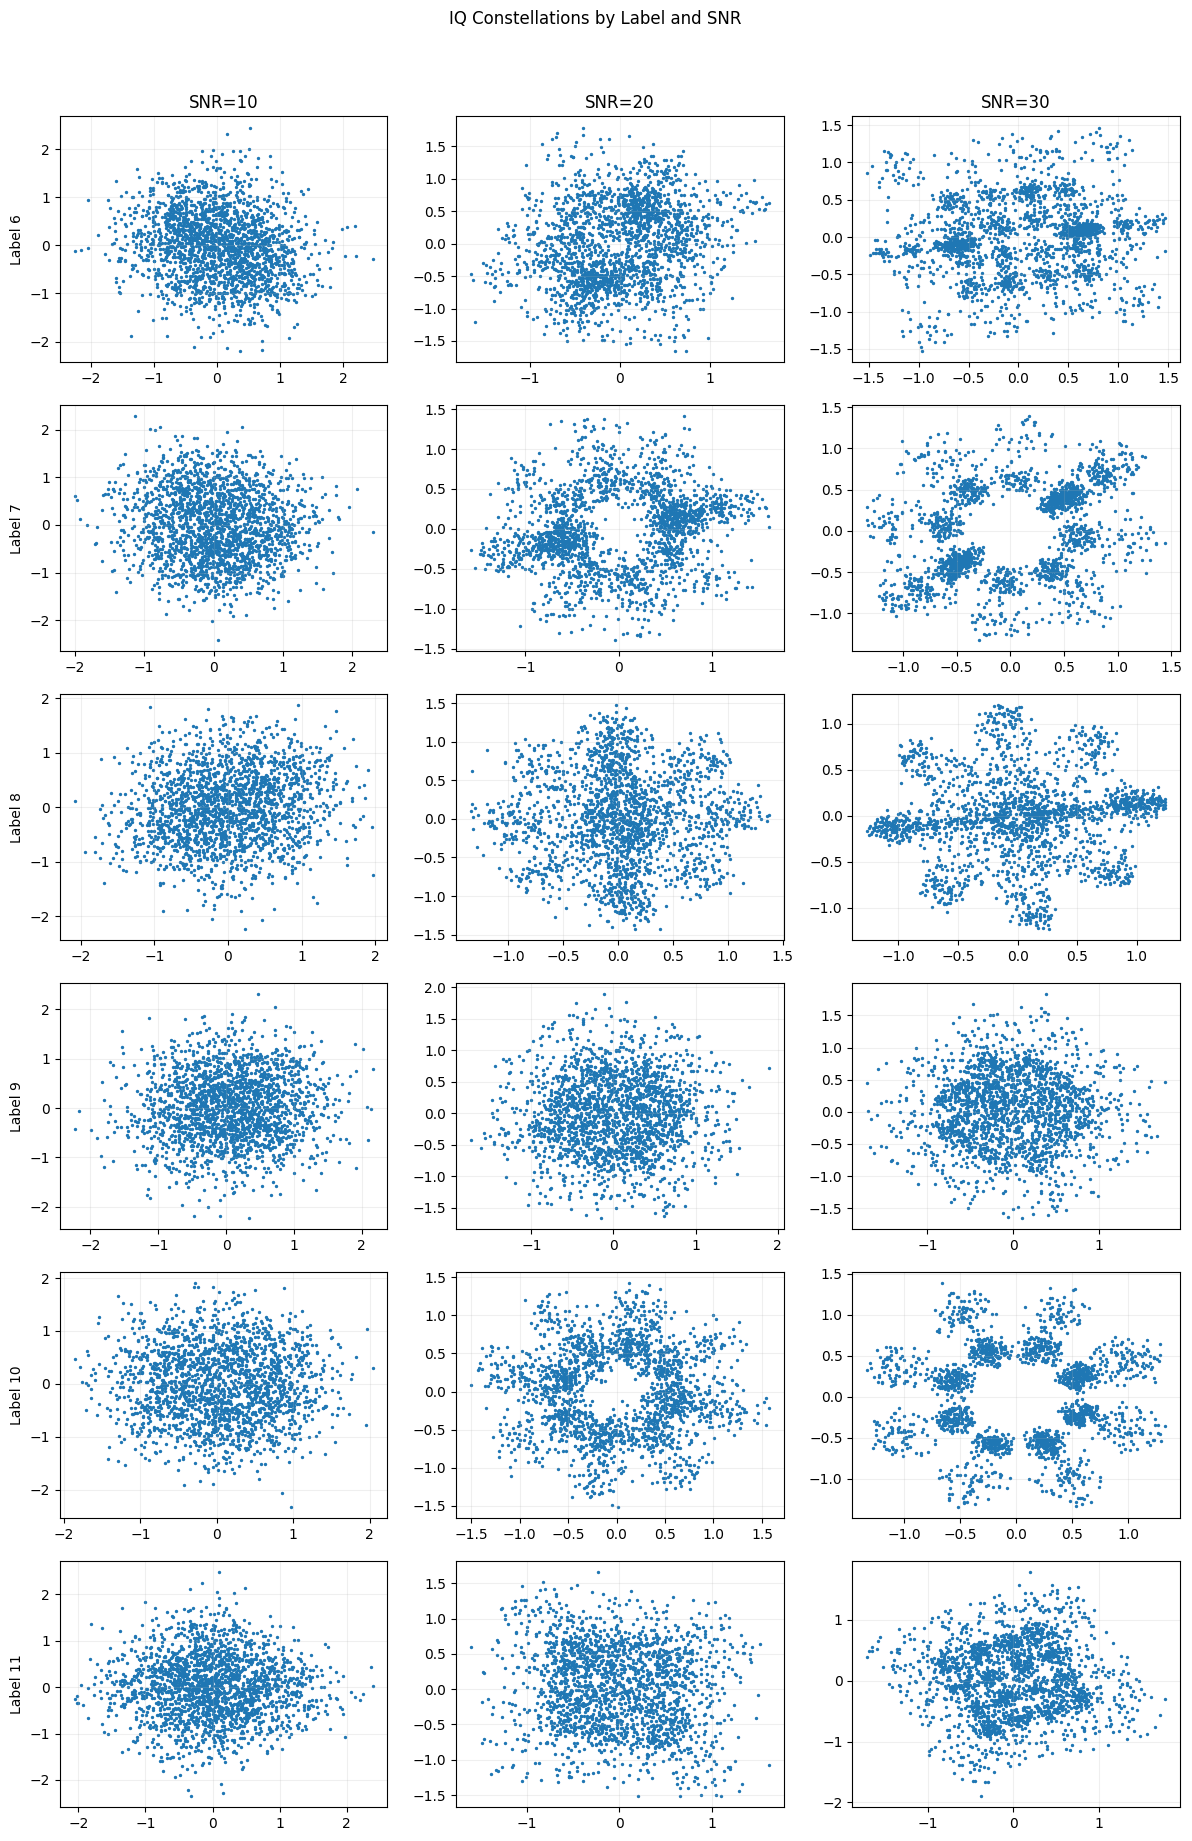

In [6]:
snr_values_sample = [10, 20, 30]
labels = [i for i in range(6,12)]

fig, axes = plt.subplots(
    nrows=len(labels),
    ncols=len(snr_values_sample),
    figsize=(4*len(snr_values_sample),3*len(labels))
)

for i, lbl in enumerate(labels):

  for j, snr in enumerate(snr_values_sample):
    ax = axes[i, j]

    # indices for this (label, snr)
    mask = (labels_id_sample == lbl) & (snr_sample == snr)
    idx = np.where(mask)[0]

    if len(idx) == 0:
      ax.set_axis_off()
      continue

    sig = signals_sample[idx[0]]  # (2048, 2)
    I = sig[:, 0]
    Q = sig[:, 1]

    ax.scatter(I, Q, s=2)
    ax.grid(alpha=0.2)

    if i == 0:
      ax.set_title(f"SNR={snr}")
    if j == 0:
      ax.set_ylabel(f"Label {lbl}")

fig.suptitle("IQ Constellations by Label and SNR", y=1.02)
plt.tight_layout()
plt.show()


## Creation du dataset 

In [7]:
class MyDataset(torch.utils.data.Dataset):
  def __init__(self, path):
    self.data = h5py.File(path , 'r')
    self.signals = torch.transpose(torch.tensor(np.array(self.data['signaux'])),1,2)
    self.labels = torch.tensor(np.array(self.data['labels']))
    self.snr = torch.tensor(np.array(self.data['snr']))
    self.data.close()
  def __len__(self):
    return self.signals.shape[0]
  def __getitem__(self,i):
    return self.signals[i],self.snr[i],self.labels[i]

## Création du réseau de neuronnes avec SNR embedding
    

In [8]:
class Reseau(nn.Module):
    def __init__(self, in_channels=2, n_classes=6,snr_emb = 8,mult=1):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv1d(in_channels, 16*mult, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.MaxPool1d(2),              # reduction par 2 augmente le champ récepteur

            nn.Conv1d(16*mult, 32*mult, kernel_size=7, padding=3), # 7, 3 pour garder la même dimmension (avec le padding)
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(32*mult, 32*mult, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.MaxPool1d(2),  # réduire par deux
        )

        # EMBedding sur snr
        self.snr_embedding = nn.Sequential(
            nn.Linear(1,snr_emb),
            nn.ReLU(),
            nn.Linear(snr_emb,snr_emb),
            nn.ReLU(),
        )
        # Classification après pooling global
        self.classifier = nn.Linear(32*mult+snr_emb, n_classes)

    def forward(self, x,snr):
        logsnr = torch.log(snr + 10) # +10 juste pour éviter log(0)
        snr_emb = self.snr_embedding(logsnr)
        x = self.features(x)              # (B, 64, L')
        x = x.mean(dim=-1)  # B, 64
        embedding = torch.concat([x,snr_emb],dim=1) # (B, 72)
        x = self.classifier(embedding)            # (B, n_classes)
        return embedding, F.log_softmax(x, dim=1)    # on renvoie a la fois l'embedding et le vecteur de proba


In [9]:
model = Reseau()

def count_n_param(model):
    return sum([p.numel() for p in model.parameters()])

print(f"Total amount of parameters of the model : {count_n_param(model)}")

Total amount of parameters of the model : 11390


## Trainning baseline : 
- on entraîne directement un classifieur supervisé sur les classes 6–11 uniquement, en limitant volontairement le nombre d’exemples disponibles par classe (nb_sample). Concrètement, pour chaque nb_sample on construit un split stratifié avec au moins 20% de validation par label, puis on entraîne le même réseau (Conv1D + embedding SNR + couche linéaire) avec une NLLLoss.

#### Utils pour sélectionner un nombre fixe de samples pour le trainning


In [10]:
def make_train_val_indices(dataset, nb_sample, val_frac_min=0.2, seed=0):
    y = dataset.labels
    uniq = torch.unique(y).tolist()

    g = torch.Generator()
    g.manual_seed(int(seed))

    train_idx_chunks, val_idx_chunks = [], []

    for lab in uniq:
        idx = torch.nonzero(y == lab, as_tuple=False).squeeze(1)
        idx = idx[torch.randperm(idx.numel(), generator=g)]  # shuffle

        n_total = idx.numel()
        n_val_min = int(np.ceil(val_frac_min * n_total))
        n_val_min = min(n_total, max(1, n_val_min))  # >=1 si possible

        n_train = min(int(nb_sample), n_total - n_val_min)

        train_idx_chunks.append(idx[:n_train])
        val_idx_chunks.append(idx[n_train:])  # val = min + reste

    train_idx = torch.cat(train_idx_chunks).tolist() if len(train_idx_chunks) else []
    val_idx   = torch.cat(val_idx_chunks).tolist() if len(val_idx_chunks) else []
    return train_idx, val_idx, uniq

def print_split_debug(dataset, train_idx, val_idx, uniq):
    y = dataset.labels
    ytr = y[train_idx]
    yva = y[val_idx]
    print(f"Train size={len(train_idx)} | Val size={len(val_idx)}")
    for lab in uniq:
        ntot = int((y == lab).sum().item())
        ntr  = int((ytr == lab).sum().item()) if len(train_idx) else 0
        nva  = int((yva == lab).sum().item()) if len(val_idx) else 0
        pct  = 100.0 * nva / max(1, ntot)
        print(f"  label={lab}: train={ntr}, val={nva} (total={ntot}, val%={pct:.1f}%)")

### saving paths

In [11]:
EXP_NAME = 'final'
BASE_DIR = os.getcwd()
RUN_DIR = os.path.join(BASE_DIR,'runs_baseline')
EXP_DIR = os.path.join(RUN_DIR,EXP_NAME)
LOSS_DIR = os.path.join(EXP_DIR,'losses')
WEIGHTS_DIR = os.path.join(EXP_DIR,'weights')

os.makedirs(EXP_DIR,exist_ok=True)
os.makedirs(LOSS_DIR,exist_ok=True)
os.makedirs(WEIGHTS_DIR,exist_ok=True)


### trainning 

In [12]:
max_samples = [1,3,5,10,15,20,50,100] # nombre max de samples utilisés par class
for nb_sample in max_samples : 
    batch_size = max(2,nb_sample)

    model_pth_name = f'model_baseline_max_samples_{nb_sample}.pth'
    
    model_baseline= Reseau().to(device)
    loss = nn.NLLLoss() # il faut renvoyer des log prob pas des prob
    optimizer = torch.optim.Adam(model_baseline.parameters())
    
    dataset_sample = MyDataset(sample_path)
    # 6-11 to 0-5 pour NLL loss
    dataset_sample.labels = dataset_sample.labels.long()-6


    train_idx,val_idx,uniq = make_train_val_indices(dataset_sample,nb_sample)
    print_split_debug(dataset_sample,train_idx,val_idx,uniq)

    dataloader_train = DataLoader(Subset(dataset_sample,train_idx),batch_size=batch_size,shuffle=True)
    dataloader_val = DataLoader(Subset(dataset_sample,val_idx),batch_size=batch_size)
    
    n_epochs = 500

    val_acc_history_name = f'val_acc_max_samples_{nb_sample}.npy'
    train_acc_history_name = f'train_acc_max_samples_{nb_sample}.npy'
    train_loss_history_name = f'train_loss_max_samples_{nb_sample}.npy'
    val_loss_history_name = f'val_loss_max_samples_{nb_sample}.npy'

    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    for epoch in range(n_epochs):

        model_baseline.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for step, (b, snr,label) in enumerate(dataloader_train, start=1):
            b = b.to(device)
            label = label.long().to(device)
            snr = snr.unsqueeze(-1).to(device)
            # print(snr.shape)

            optimizer.zero_grad()

            _,outputs = model_baseline(b,snr)                 
            l = loss(outputs, label)

            l.backward()
            optimizer.step()

            running_loss += l.item() * b.size(0)

            # calcul accuracy
            preds = outputs.argmax(dim=1)
            correct_train += (preds == label).sum().item()
            total_train += label.size(0)

        epoch_train_loss = running_loss / total_train
        epoch_train_acc = correct_train / total_train
        train_loss_history.append(epoch_train_loss)
        train_acc_history.append(epoch_train_acc)

        model_baseline.eval()
        val_running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for b, snr,label in dataloader_val:
                b = b.to(device)
                label = label.long().to(device)
                snr = snr.unsqueeze(-1).to(device)


                _,outputs = model_baseline(b,snr)
                l_val = loss(outputs, label)

                val_running_loss += l_val.item()*b.size(0)

                preds = outputs.argmax(dim=1)
                correct_val += (preds==label).sum().item()
                total_val+= label.size(0)

        epoch_val_loss = val_running_loss / total_val
        epoch_val_acc = correct_val / total_val
        val_loss_history.append(epoch_val_loss)
        val_acc_history.append(epoch_val_acc)

        print(
            f"Epoch {epoch+1}/{n_epochs} "
            f"- train loss={epoch_train_loss:.4f}, train acc={epoch_train_acc*100:.2f}% "
            f"- val loss={epoch_val_loss:.4f}, val acc={epoch_val_acc*100:.2f}%"
        )

    epochs = np.arange(1, n_epochs + 1)

    torch.save(model_baseline.state_dict(), os.path.join(WEIGHTS_DIR,model_pth_name))
    print(f"Model saved to {os.path.join(WEIGHTS_DIR,model_pth_name)}")
    np.save(os.path.join(LOSS_DIR, val_acc_history_name),   np.array(val_acc_history))
    np.save(os.path.join(LOSS_DIR, train_acc_history_name), np.array(train_acc_history))
    np.save(os.path.join(LOSS_DIR, val_loss_history_name),  np.array(val_loss_history))
    np.save(os.path.join(LOSS_DIR, train_loss_history_name),np.array(train_loss_history))



    

Train size=6 | Val size=494
  label=0: train=1, val=92 (total=93, val%=98.9%)
  label=1: train=1, val=98 (total=99, val%=99.0%)
  label=2: train=1, val=77 (total=78, val%=98.7%)
  label=3: train=1, val=65 (total=66, val%=98.5%)
  label=4: train=1, val=74 (total=75, val%=98.7%)
  label=5: train=1, val=88 (total=89, val%=98.9%)


Epoch 1/500 - train loss=1.8284, train acc=16.67% - val loss=1.8011, val acc=18.62%
Epoch 2/500 - train loss=1.8157, train acc=16.67% - val loss=1.7992, val acc=18.62%
Epoch 3/500 - train loss=1.8107, train acc=16.67% - val loss=1.7982, val acc=18.62%
Epoch 4/500 - train loss=1.8086, train acc=16.67% - val loss=1.7975, val acc=18.62%
Epoch 5/500 - train loss=1.8086, train acc=16.67% - val loss=1.7967, val acc=18.62%
Epoch 6/500 - train loss=1.8058, train acc=16.67% - val loss=1.7960, val acc=18.62%
Epoch 7/500 - train loss=1.8045, train acc=16.67% - val loss=1.7956, val acc=18.62%
Epoch 8/500 - train loss=1.8036, train acc=16.67% - val loss=1.7958, val acc=18.62%
Epoch 9/500 - train loss=1.8038, train acc=16.67% - val loss=1.7946, val acc=18.62%
Epoch 10/500 - train loss=1.8021, train acc=16.67% - val loss=1.7941, val acc=18.62%
Epoch 11/500 - train loss=1.8014, train acc=16.67% - val loss=1.7940, val acc=18.62%
Epoch 12/500 - train loss=1.8001, train acc=16.67% - val loss=1.7933, val 

### Performances de la baseline
* On affiche :  courbes train/val loss et train/val accuracy, confusion matrix sur le test, ainsi que la test accuracy et l’écart max(train acc) − test acc en fonction de `nb_sample`.


labels min/max after remap: 0 5

==== nb_sample=1 | n_epochs=500 ====
Last epoch: train loss=0.0123, val loss=15.2352, train acc=100.00%, val acc=23.68%


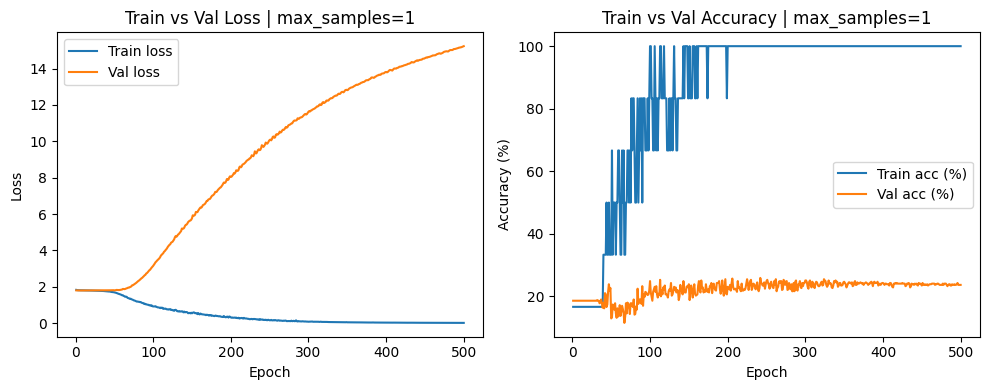

Final test accuracy: 0.2740 (27.40%) | max_samples=1
Confusion matrix:
 [[13  0 32 35  0 10]
 [ 9  0 12 39  3 11]
 [ 7  0 44 13  0 13]
 [ 0  0  4 30  0 55]
 [ 0  0 22 30  0 31]
 [ 0  0  7 30  0 50]]


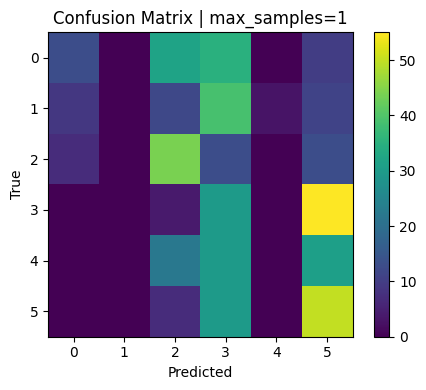


==== nb_sample=3 | n_epochs=500 ====
Last epoch: train loss=0.0641, val loss=9.9665, train acc=100.00%, val acc=35.89%


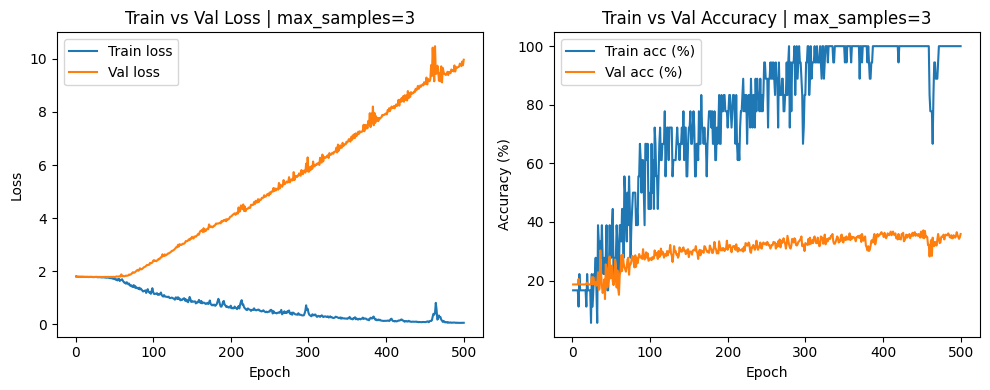

Final test accuracy: 0.3100 (31.00%) | max_samples=3
Confusion matrix:
 [[21 12 15  4 26 12]
 [16 22 12  0 18  6]
 [ 2  0 27  0 23 25]
 [ 1  0  3  1 24 60]
 [ 3  0  9  2 26 43]
 [ 2  0  4  3 20 58]]


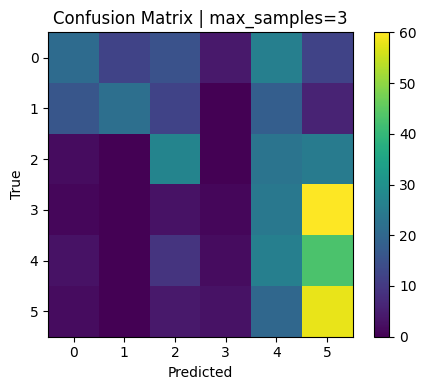


==== nb_sample=5 | n_epochs=500 ====
Last epoch: train loss=0.5831, val loss=3.2943, train acc=83.33%, val acc=26.81%


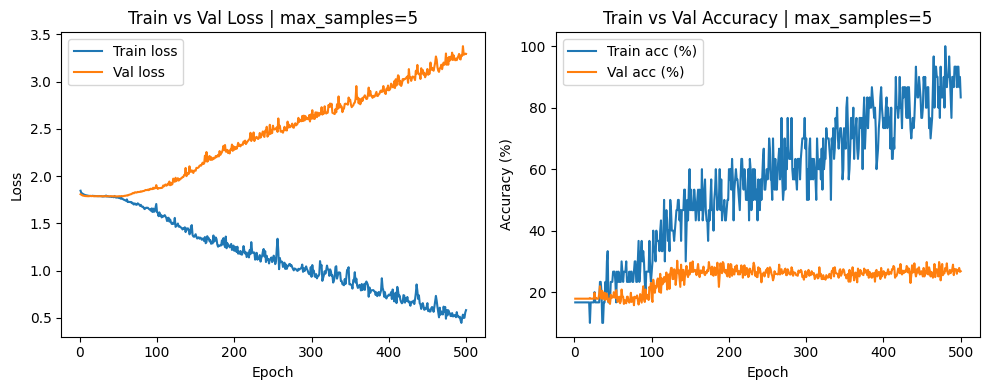

Final test accuracy: 0.2820 (28.20%) | max_samples=5
Confusion matrix:
 [[37 22  2  8 15  6]
 [25 22  8  6  7  6]
 [ 2 18 18  9 26  4]
 [11 11  0  6 55  6]
 [ 7 11  0  9 50  6]
 [ 5  9  0  9 56  8]]


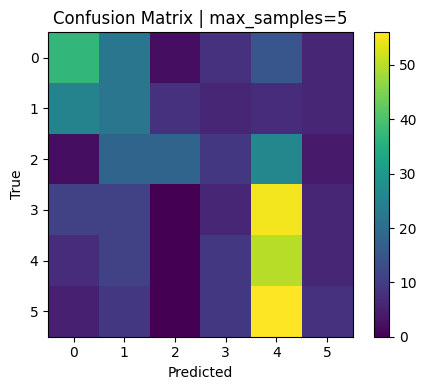


==== nb_sample=10 | n_epochs=500 ====
Last epoch: train loss=0.6962, val loss=1.7460, train acc=70.00%, val acc=36.14%


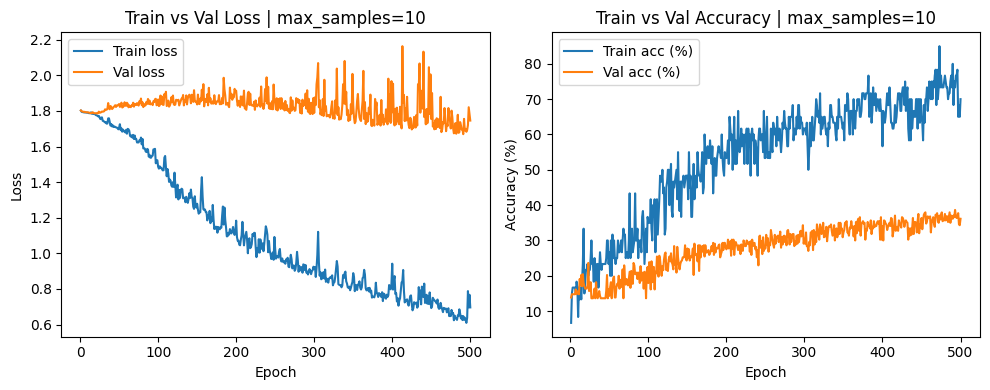

Final test accuracy: 0.3060 (30.60%) | max_samples=10
Confusion matrix:
 [[40 22  1  4 16  7]
 [16 35  0  2 13  8]
 [57  1 19  0  0  0]
 [16 27  0 13  9 24]
 [19 28  0  1 28  7]
 [19 34  0 10  6 18]]


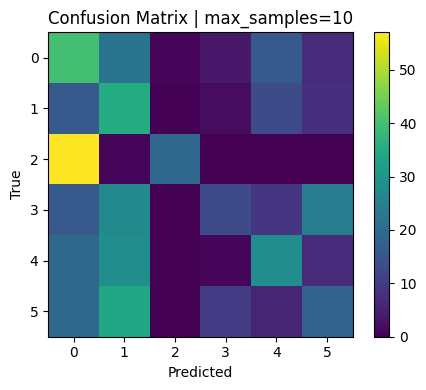


==== nb_sample=15 | n_epochs=500 ====
Last epoch: train loss=0.5977, val loss=1.5071, train acc=80.00%, val acc=41.46%


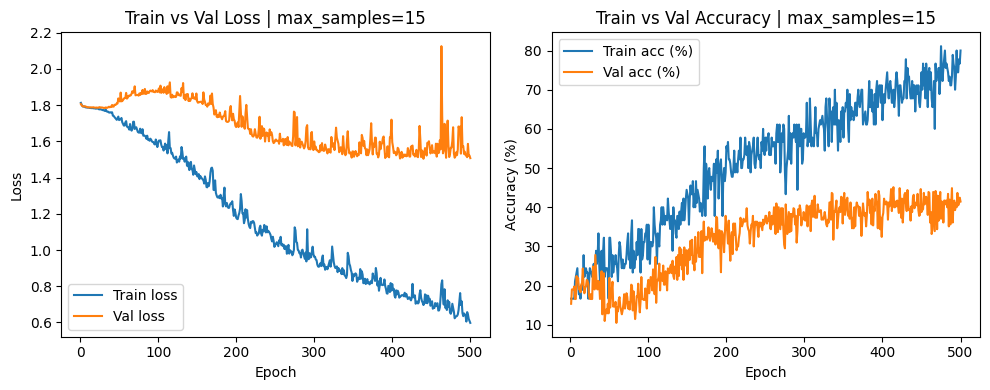

Final test accuracy: 0.3900 (39.00%) | max_samples=15
Confusion matrix:
 [[25 29  0  5 31  0]
 [17 33  0 10  9  5]
 [ 0  7 51  0 19  0]
 [11 26  0 15  6 31]
 [ 5 31  0  1 41  5]
 [ 9 27  0 16  5 30]]


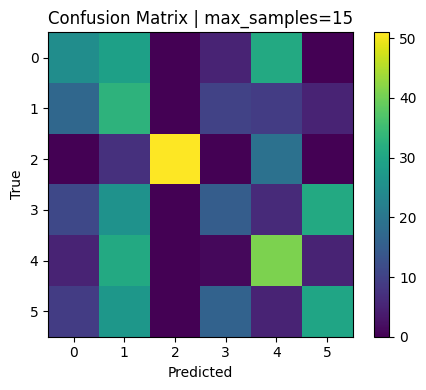


==== nb_sample=20 | n_epochs=500 ====
Last epoch: train loss=0.4566, val loss=0.9914, train acc=82.50%, val acc=52.11%


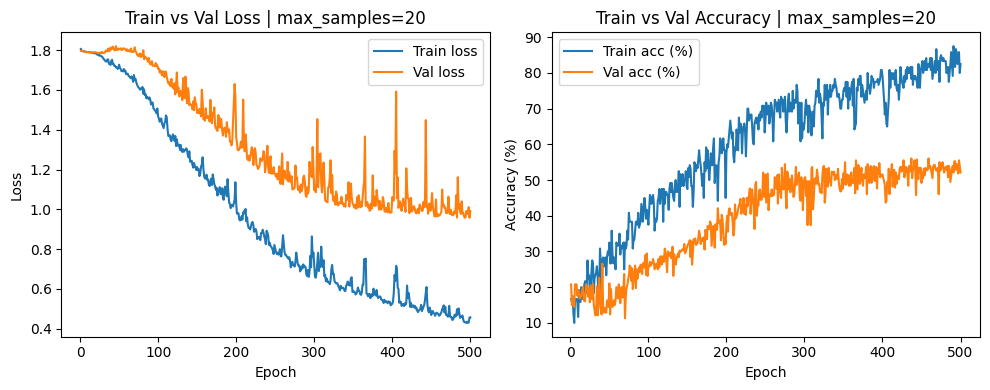

Final test accuracy: 0.5120 (51.20%) | max_samples=20
Confusion matrix:
 [[58 16  0  2  0 14]
 [17 47  0  0  4  6]
 [ 0  8 55  0 13  1]
 [21  1  0 11  0 56]
 [ 5 45  0  0 32  1]
 [21  0  0 13  0 53]]


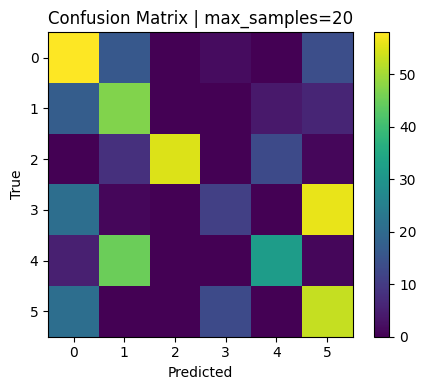


==== nb_sample=50 | n_epochs=500 ====
Last epoch: train loss=0.4683, val loss=0.6866, train acc=80.67%, val acc=66.50%


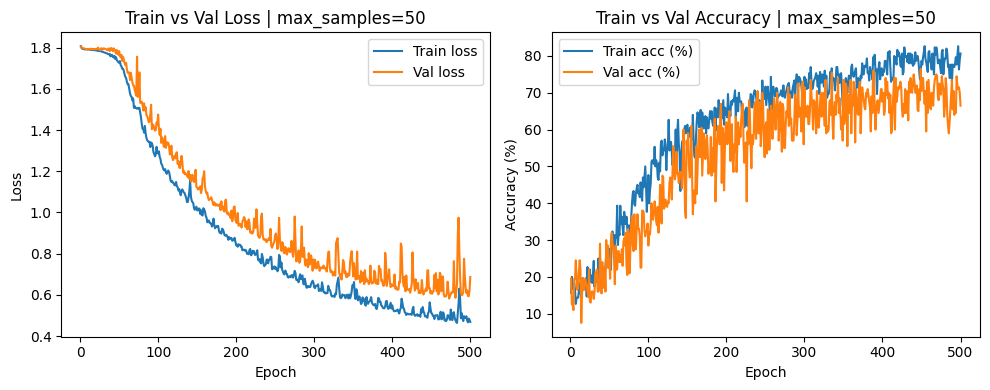

Final test accuracy: 0.6260 (62.60%) | max_samples=50
Confusion matrix:
 [[75 10  2  0  3  0]
 [ 0 27  1  0 46  0]
 [ 0  0 76  0  1  0]
 [26  0  0 26  0 37]
 [ 0 11  2  0 70  0]
 [28  0  0 20  0 39]]


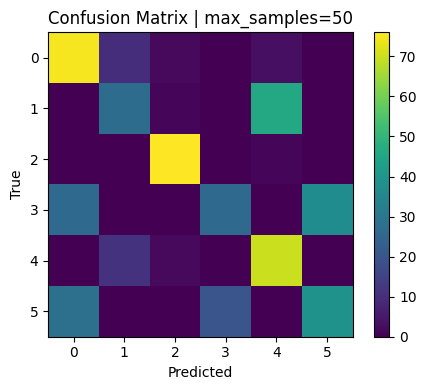


==== nb_sample=100 | n_epochs=500 ====
Last epoch: train loss=0.4909, val loss=0.5614, train acc=77.89%, val acc=66.67%


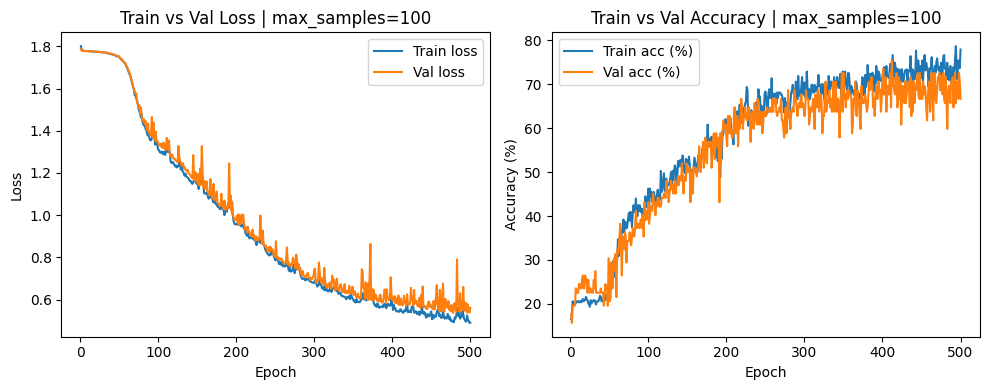

Final test accuracy: 0.6180 (61.80%) | max_samples=100
Confusion matrix:
 [[84  0  0  2  0  4]
 [ 8 39  3  0 23  1]
 [ 0  0 77  0  0  0]
 [21  0  0 33  0 35]
 [ 3 46  0  0 34  0]
 [16  0  0 29  0 42]]


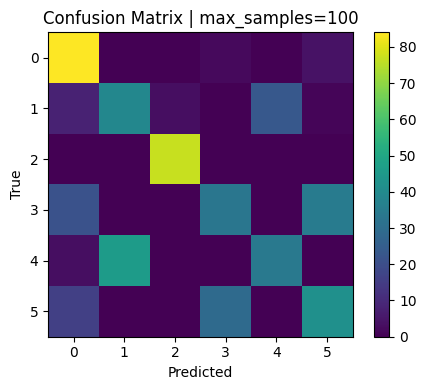

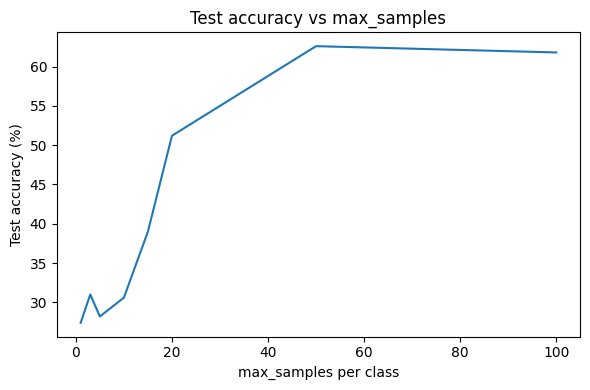

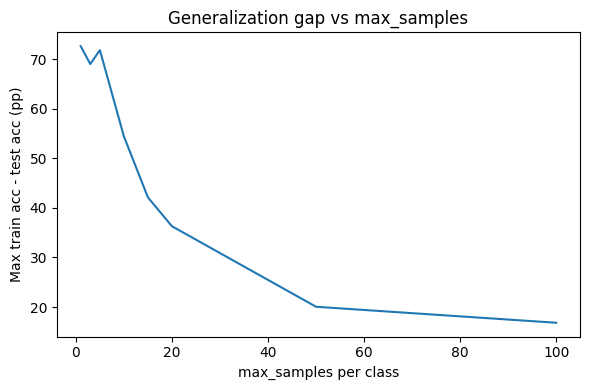

In [13]:
num_classes = 6
dataset_test = MyDataset(test_path)
dataset_test.labels = dataset_test.labels.long() - 6
print("labels min/max after remap:", dataset_test.labels.min().item(), dataset_test.labels.max().item())


dataloader_test = DataLoader(dataset_test,batch_size=16)

test_acc_list = []
max_train_acc_list = []
gap_train_test_list = []

# on regarde les perfs pour chaque nb_sample
for nb_sample in max_samples:

    # load des loss et acc de training/val
    val_acc_history_name   = f'val_acc_max_samples_{nb_sample}.npy'
    train_acc_history_name = f'train_acc_max_samples_{nb_sample}.npy'
    train_loss_history_name= f'train_loss_max_samples_{nb_sample}.npy'
    val_loss_history_name  = f'val_loss_max_samples_{nb_sample}.npy'

    train_loss_history = np.load(os.path.join(LOSS_DIR, train_loss_history_name))
    val_loss_history   = np.load(os.path.join(LOSS_DIR, val_loss_history_name))
    train_acc_history  = np.load(os.path.join(LOSS_DIR, train_acc_history_name))
    val_acc_history    = np.load(os.path.join(LOSS_DIR, val_acc_history_name))

 
    max_train_acc = float(np.max(train_acc_history))
    max_train_acc_list.append(max_train_acc)
  

    n_epochs = len(train_loss_history)
    epochs = np.arange(1, n_epochs + 1)

    print(f"\n==== nb_sample={nb_sample} | n_epochs={n_epochs} ====")
    print(f"Last epoch: train loss={train_loss_history[-1]:.4f}, val loss={val_loss_history[-1]:.4f}, "
          f"train acc={100*np.array(train_acc_history[-1]):.2f}%, val acc={100*np.array(val_acc_history[-1]):.2f}%")

    plt.figure(figsize=(10,4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss_history, label='Train loss')
    plt.plot(epochs, val_loss_history, label='Val loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Train vs Val Loss | max_samples={nb_sample}')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, np.array(train_acc_history)*100, label='Train acc (%)')
    plt.plot(epochs, np.array(val_acc_history)*100, label='Val acc (%)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title(f'Train vs Val Accuracy | max_samples={nb_sample}')
    plt.legend()

    plt.tight_layout()
    plt.show()


    # load models 
    model_pth_name = f'model_baseline_max_samples_{nb_sample}.pth'
    model_path = os.path.join(WEIGHTS_DIR, model_pth_name)

    model1 = Reseau().to(device)
    model1.load_state_dict(torch.load(model_path, map_location=device))
    model1.eval()

    # confusion matrice sur le test
    cm_metric = MulticlassConfusionMatrix(num_classes=num_classes)
    correct = 0
    total = 0

    with torch.no_grad():
        for b_test, snr_test, label_test in dataloader_test:
            b_test = b_test.to(device)
            label_test = label_test.long().to(device)
            snr_test = snr_test.unsqueeze(-1).to(device)

            out = model1(b_test, snr_test)
            outputs = out[1] if isinstance(out, (tuple, list)) else out

            preds = outputs.argmax(dim=1)

            correct += (preds == label_test).sum().item()
            total += label_test.size(0)

            cm_metric.update(preds.cpu(), label_test.cpu())

    test_acc = correct / max(1, total)
    print(f"Final test accuracy: {test_acc:.4f} ({test_acc*100:.2f}%) | max_samples={nb_sample}")

    test_acc_list.append(float(test_acc))
    gap_train_test_list.append(float(max_train_acc - test_acc))

    cm = cm_metric.compute().numpy()
    print("Confusion matrix:\n", cm)

    plt.figure(figsize=(5, 4))
    plt.imshow(cm, interpolation='nearest')
    plt.title(f'Confusion Matrix | max_samples={nb_sample}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.colorbar()
    plt.xticks(range(num_classes))
    plt.yticks(range(num_classes))
    plt.tight_layout()
    plt.show()


plt.figure(figsize=(6, 4))
plt.plot(max_samples, np.array(test_acc_list) * 100)
plt.xlabel('max_samples per class')
plt.ylabel('Test accuracy (%)')
plt.title('Test accuracy vs max_samples')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(max_samples, np.array(gap_train_test_list) * 100)
plt.xlabel('max_samples per class')
plt.ylabel('Max train acc - test acc (pp)')
plt.title('Generalization gap vs max_samples')
plt.tight_layout()
plt.show()
# <<<


### Commentaires resultats baseline : 
Plusieurs choses :

* On voit très clairement que lorsque l’on utilise peu de samples du dataset on overfit très vite (val loss qui augmente pendant le trainning). On a affiché l’écart entre train et test accuracy sur le dernier plot : on voit clairement que l’écart entre les deux diminue quand on augmente `nb_sample`, signe qu’on réduit l’overfitting.

* On obtient donc une méthode baseline très naïve qui commence à performer décemment (60% accuracy) seulement à partir de 50 samples/per label, ce qui fait en soi déjà beacoup de samples.

Au vu de la tête des signaux 6–11, qui sont du même type que 0–5 (ce sont des modulations, donc même famille de signaux ; on le voit clairement quand on les affiche en IQ), on aimerait pouvoir exploiter les nombreux samples 0–5 c'est à dire généraliser ce qu'on apprend sur eux.




## Notre méthode
L’idée générale est donc la suivante : on a 0–5 qui sont globalement des signaux similaires, donc on peut apprendre un encodeur qui extrait des features robustes et qui s’adapte vite à peu de nouvelles données (via episodic training, comme décrit dans le papier), puis l’adapter sur nos nouvelles classes 6–11.
### Trainning du prototypical encoder
On entraîne l’encodeur sur 0–5 avec des épisodes (support/query), puis au test on construira un prototype par classe 6–11 à partir de Z shots et on classe par plus proche prototype dans l’espace d’embedding.


In [43]:
EXP_NAME_PROTO = "test"
RUN_DIR_PROTO = os.path.join(BASE_DIR, "runs_prototypes")
EXP_DIR_PROTO = os.path.join(RUN_DIR_PROTO, EXP_NAME_PROTO)
LOSS_DIR_PROTO = os.path.join(EXP_DIR_PROTO, "losses")
WEIGHTS_DIR_PROTO = os.path.join(EXP_DIR_PROTO, "weights")

os.makedirs(EXP_DIR_PROTO, exist_ok=True)
os.makedirs(LOSS_DIR_PROTO, exist_ok=True)
os.makedirs(WEIGHTS_DIR_PROTO, exist_ok=True)


On prépare les datasets de base (train/val sur 0–5) et on enlève les échantillons à SNR=0 puisque il n'y a pas d'écahntillons avec ce SNR dans le dataset 6-11.


In [ ]:
# datasets base (0-5)
dataset_train = MyDataset(train_path)
dataset_val   = MyDataset(validation_path)

# on enlève sample ou SNR == 0
mask_train = dataset_train.snr != 0
mask_val   = dataset_val.snr != 0

dataset_train.signals = dataset_train.signals[mask_train]
dataset_train.snr     = dataset_train.snr[mask_train]
dataset_train.labels  = dataset_train.labels[mask_train]

dataset_val.signals = dataset_val.signals[mask_val]
dataset_val.snr     = dataset_val.snr[mask_val]
dataset_val.labels  = dataset_val.labels[mask_val]

print("Train base size (snr!=0):", len(dataset_train), "| Val base size (snr!=0):", len(dataset_val))
print("Train labels:", torch.unique(dataset_train.labels).tolist(), "| Val labels:", torch.unique(dataset_val.labels).tolist())
print("Train snr min/max:", dataset_train.snr.min().item(), dataset_train.snr.max().item())

# --- D_k tensors 
D_k_tensors = {}
D_k_val_tensors = {}

for k in range(6):
    mask_k = (dataset_train.labels == k)
    mask_kv = (dataset_val.labels == k)
    D_k_tensors[k] = (dataset_train.signals[mask_k], dataset_train.snr[mask_k], dataset_train.labels[mask_k])
    D_k_val_tensors[k] = (dataset_val.signals[mask_kv], dataset_val.snr[mask_kv], dataset_val.labels[mask_kv])

# Episode sampling + prototypical loss 
@torch.no_grad()
def _sample_episode(D_k_tensors, class_ids, N_s, N_q, device):
    support_x, support_snr, support_y = [], [], []
    query_x, query_snr, query_y = [], [], []

    for new_y, k in enumerate(class_ids):
        Xk, SNRk, _ = D_k_tensors[int(k)]
        Xk = Xk.float()
        SNRk = SNRk.float()

        n = Xk.shape[0]
        m = N_s + N_q

        if n >= m:
            idx = torch.randperm(n)[:m]
        else:
            idx = torch.randint(0, n, (m,))

        s_idx = idx[:N_s]
        q_idx = idx[N_s:]

        support_x.append(Xk[s_idx])
        support_snr.append(SNRk[s_idx])
        support_y.append(torch.full((N_s,), new_y, dtype=torch.long))

        query_x.append(Xk[q_idx])
        query_snr.append(SNRk[q_idx])
        query_y.append(torch.full((N_q,), new_y, dtype=torch.long))

    support_x = torch.cat(support_x, dim=0).to(device)
    support_snr = torch.cat(support_snr, dim=0).to(device).unsqueeze(1)
    support_y = torch.cat(support_y, dim=0).to(device)

    query_x = torch.cat(query_x, dim=0).to(device)
    query_snr = torch.cat(query_snr, dim=0).to(device).unsqueeze(1)
    query_y = torch.cat(query_y, dim=0).to(device)

    return support_x, support_snr, support_y, query_x, query_snr, query_y

def prototypical_loss(model, D_k_tensors, N_s, N_q, N_c, device):
    K = len(D_k_tensors)
    class_ids = torch.randperm(K)[:N_c]

    support_x, support_snr, _, query_x, query_snr, query_y = _sample_episode(
        D_k_tensors, class_ids, N_s, N_q, device
    )

    z_support, _ = model(support_x, support_snr)  # (N_c*N_s, d)
    z_query, _   = model(query_x, query_snr)      # (N_c*N_q, d)

    d = z_support.shape[-1]
    prototypes = z_support.view(N_c, N_s, d).mean(dim=1)  # (N_c, d)

    dists = torch.cdist(z_query, prototypes) ** 2         # (N_c*N_q, N_c)
    logits = -dists

    loss = F.cross_entropy(logits, query_y)
    acc = (logits.argmax(dim=1) == query_y).float().mean()

    return loss, acc


Train base size (snr!=0): 22340 | Val base size (snr!=0): 7540
Train labels: [0, 1, 2, 3, 4, 5] | Val labels: [0, 1, 2, 3, 4, 5]
Train snr min/max: 10 30


In [32]:
epochs = 60
episodes_per_epoch = 200
val_episodes = 50

N_s = 5
N_q = 15
N_c = 6

model_pth_name = f"proto_encoder_Ns{N_s}_Nq{N_q}_Nc{N_c}.pth"
train_loss_name = f"train_loss_proto_Ns{N_s}_Nq{N_q}_Nc{N_c}.npy"
val_loss_name   = f"val_loss_proto_Ns{N_s}_Nq{N_q}_Nc{N_c}.npy"
train_acc_name  = f"train_acc_proto_Ns{N_s}_Nq{N_q}_Nc{N_c}.npy"
val_acc_name    = f"val_acc_proto_Ns{N_s}_Nq{N_q}_Nc{N_c}.npy"


In [33]:

model_proto = Reseau(mult=2).to(device)
print(f"Total amount of parameters of the model : {count_n_param(model_proto)}")
optimizer = torch.optim.Adam(model_proto.parameters(), amsgrad=True)

train_loss_hist, val_loss_hist = [], []
train_acc_hist,  val_acc_hist  = [], []

for epoch in range(1, epochs + 1):
    model_proto.train()
    loss_sum, acc_sum = 0.0, 0.0

    for _ in range(episodes_per_epoch):
        optimizer.zero_grad(set_to_none=True)
        loss, acc = prototypical_loss(model_proto, D_k_tensors, N_s, N_q, N_c, device)
        loss.backward()
        optimizer.step()
        loss_sum += loss.item()
        acc_sum += acc.item()

    epoch_train_loss = loss_sum / episodes_per_epoch
    epoch_train_acc  = acc_sum / episodes_per_epoch
    train_loss_hist.append(epoch_train_loss)
    train_acc_hist.append(epoch_train_acc)

    # val
    model_proto.eval()
    vloss_sum, vacc_sum = 0.0, 0.0
    with torch.no_grad():
        for _ in range(val_episodes):
            vloss, vacc = prototypical_loss(model_proto, D_k_val_tensors, N_s, N_q, N_c, device)
            vloss_sum += vloss.item()
            vacc_sum += vacc.item()

    epoch_val_loss = vloss_sum / val_episodes
    epoch_val_acc  = vacc_sum / val_episodes
    val_loss_hist.append(epoch_val_loss)
    val_acc_hist.append(epoch_val_acc)

    print(
        f"Epoch {epoch:03d}/{epochs} "
        f"- train loss={epoch_train_loss:.4f}, train acc={epoch_train_acc*100:.2f}% "
        f"- val loss={epoch_val_loss:.4f}, val acc={epoch_val_acc*100:.2f}%"
    )

# save weights + curves
torch.save(model_proto.state_dict(), os.path.join(WEIGHTS_DIR_PROTO, model_pth_name))
print("Model saved to", os.path.join(WEIGHTS_DIR_PROTO, model_pth_name))

np.save(os.path.join(LOSS_DIR_PROTO, train_loss_name), np.array(train_loss_hist))
np.save(os.path.join(LOSS_DIR_PROTO, val_loss_name),   np.array(val_loss_hist))
np.save(os.path.join(LOSS_DIR_PROTO, train_acc_name),  np.array(train_acc_hist))
np.save(os.path.join(LOSS_DIR_PROTO, val_acc_name),    np.array(val_acc_hist))
print("Loss/acc saved to", LOSS_DIR_PROTO)


Total amount of parameters of the model : 44142
Epoch 001/60 - train loss=0.9341, train acc=49.08% - val loss=0.5694, val acc=65.58%
Epoch 002/60 - train loss=0.5026, train acc=66.19% - val loss=0.4857, val acc=66.69%
Epoch 003/60 - train loss=0.4827, train acc=67.30% - val loss=0.4769, val acc=67.00%
Epoch 004/60 - train loss=0.4619, train acc=71.24% - val loss=0.4194, val acc=76.76%
Epoch 005/60 - train loss=0.3820, train acc=78.21% - val loss=0.3297, val acc=80.29%
Epoch 006/60 - train loss=0.3115, train acc=80.51% - val loss=0.3003, val acc=80.80%
Epoch 007/60 - train loss=0.2956, train acc=81.47% - val loss=0.2896, val acc=81.13%
Epoch 008/60 - train loss=0.2939, train acc=81.32% - val loss=0.2901, val acc=81.78%
Epoch 009/60 - train loss=0.2737, train acc=81.55% - val loss=0.2709, val acc=81.89%
Epoch 010/60 - train loss=0.2685, train acc=82.16% - val loss=0.2824, val acc=81.53%
Epoch 011/60 - train loss=0.2657, train acc=82.01% - val loss=0.2749, val acc=81.91%
Epoch 012/60 - tr

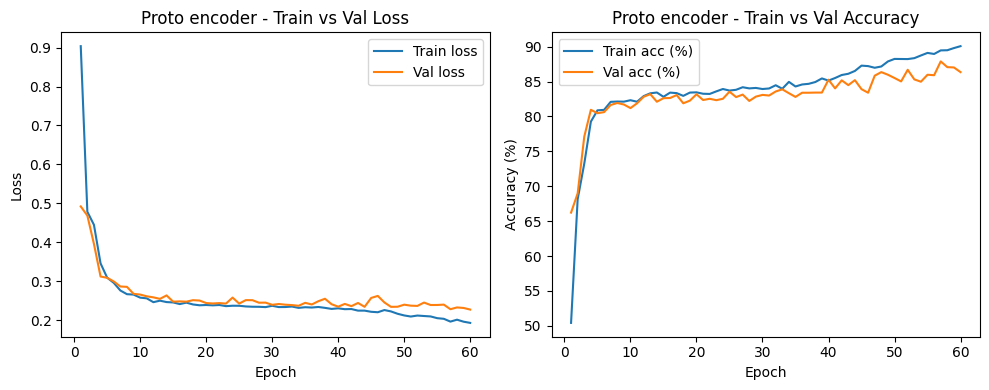

In [44]:
# load courbes
train_loss_hist = np.load(os.path.join(LOSS_DIR_PROTO, train_loss_name))
val_loss_hist = np.load(os.path.join(LOSS_DIR_PROTO, val_loss_name))
train_acc_hist = np.load(os.path.join(LOSS_DIR_PROTO, train_acc_name))
val_acc_hist = np.load(os.path.join(LOSS_DIR_PROTO, val_acc_name))

epochs_arr = np.arange(1, len(train_loss_hist) + 1)

plt.figure(figsize=(10,4))

plt.subplot(1, 2, 1)
plt.plot(epochs_arr, train_loss_hist, label="Train loss")
plt.plot(epochs_arr, val_loss_hist, label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Proto encoder - Train vs Val Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_arr, train_acc_hist*100, label="Train acc (%)")
plt.plot(epochs_arr, val_acc_hist*100, label="Val acc (%)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Proto encoder - Train vs Val Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


### Calcul des prototypes

Une fois l’encodeur appris sur 0–5, on le fige et on l’utilise sur les nouvelles classes 6–11 : on calcule un prototype par label (moyenne des embeddings) à partir de Z samples labellisés, puis on classe les données test par plus proche prototype.
On évalue la méthode pour les mêmes valeurs de Z que la baseline (1,3,5,10,15,20,50,100) afin de comparer directement les performances.


#### Calcul d'un protype par label

In [45]:

# load weights
model_proto_loaded = Reseau(mult=2).to(device)
model_proto_loaded.load_state_dict(torch.load(os.path.join(WEIGHTS_DIR_PROTO, model_pth_name), map_location=device))
model_proto_loaded.eval()
print("Loaded model:", os.path.join(WEIGHTS_DIR_PROTO, model_pth_name))

@torch.no_grad()
def compute_prototypes(
    model,
    enroll_dataset,
    labels=(6, 7, 8, 9, 10, 11),
    n_shots=None,
    batch_size=256,
    device="cuda",
    seed=0,
):
    model.eval()
    dl = DataLoader(enroll_dataset, batch_size=batch_size, shuffle=False)

    sums = {k: None for k in labels}
    counts = {k: 0 for k in labels}

    shot_indices = None
    if n_shots is not None:
        g = torch.Generator().manual_seed(seed)
        shot_indices = {}
        for k in labels:
            idx_k = torch.where(enroll_dataset.labels == k)[0]
            if idx_k.numel() < n_shots:
                raise ValueError(f"Not enough enroll samples for label {k}: {idx_k.numel()} < {n_shots}")
            perm = idx_k[torch.randperm(idx_k.numel(), generator=g)[:n_shots]]
            shot_indices[k] = set(perm.tolist())

    global_idx = 0
    for x, snr, y in dl:
        b = x.shape[0]
        x = x.float().to(device)
        snr = snr.float().to(device).unsqueeze(1)
        y = y.long().to(device)

        z, _ = model(x, snr)

        for k in labels:
            mask = (y == k)

            if shot_indices is not None and mask.any():
                idxs = torch.arange(global_idx, global_idx + b, device=device)[mask]
                keep = torch.tensor([i.item() in shot_indices[k] for i in idxs], device=device, dtype=torch.bool)
                z_k = z[mask][keep] if keep.any() else None
            else:
                z_k = z[mask] if mask.any() else None

            if z_k is not None and z_k.numel() > 0:
                sums[k] = z_k.sum(dim=0) if sums[k] is None else (sums[k] + z_k.sum(dim=0))
                counts[k] += z_k.shape[0]

        global_idx += b

    prototypes = {}
    for k in labels:
        if counts[k] == 0:
            raise ValueError(f"Prototype for label {k} has 0 samples.")
        prototypes[k] = (sums[k] / counts[k]).detach().cpu()

    return prototypes

@torch.no_grad()
def evaluate_with_prototypes(
    model,
    test_dataset,
    prototypes,
    batch_size=256,
    device="cuda",
):
    model.eval()

    labels = sorted(prototypes.keys())                     # [6..11]
    proto_mat = torch.stack([prototypes[k] for k in labels], dim=0).to(device)  # (C, d)
    label_tensor = torch.tensor(labels, device=device, dtype=torch.long)         # (C,)

    dl = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    correct = 0
    total = 0
    per_label = {k: {"correct": 0, "total": 0} for k in labels}

    # pour confusion matrix (6..11 affichés)
    C = len(labels)
    cm = torch.zeros(C, C, dtype=torch.long)
    lab2i = {lab: i for i, lab in enumerate(labels)}

    for x, snr, y in dl:
        x = x.float().to(device)
        snr = snr.float().to(device).unsqueeze(1)
        y = y.long().to(device)

        z, _ = model(x, snr)

        dists = torch.cdist(z, proto_mat)**2 # (B, C)
        pred = label_tensor[dists.argmin(dim=1)]# (B,) 

        total += y.numel()
        correct += (pred == y).sum().item()

        # per-label
        for k in labels:
            m = (y == k)
            if m.any():
                per_label[k]["total"] += m.sum().item()
                per_label[k]["correct"] += (pred[m] == y[m]).sum().item()

        # confusion matrix (CPU)
        pred_cpu = pred.detach().cpu().tolist()
        y_cpu = y.detach().cpu().tolist()
        for yt, yp in zip(y_cpu, pred_cpu):
            cm[lab2i[yt], lab2i[yp]] += 1

    acc = correct / total
    per_label_acc = {k: per_label[k]["correct"] / per_label[k]["total"] for k in labels}
    return acc, per_label_acc, cm.numpy(), labels


Loaded model: /home/infres/rplanchon-23/code/FewShots/runs_prototypes/test/weights/proto_encoder_Ns5_Nq15_Nc6.pth



Overall acc (prototypes, Z=1 | Z_eff=1): 0.6420 (64.20%)
Per-label acc: {6: 0.8666666666666667, 7: 0.14864864864864866, 8: 0.935064935064935, 9: 0.30337078651685395, 10: 0.9518072289156626, 11: 0.6206896551724138}


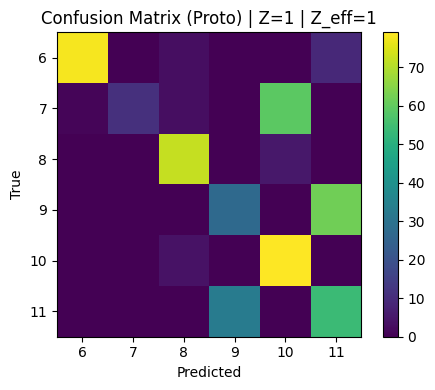


Overall acc (prototypes, Z=3 | Z_eff=3): 0.7020 (70.20%)
Per-label acc: {6: 0.9777777777777777, 7: 0.40540540540540543, 8: 0.8701298701298701, 9: 0.15730337078651685, 10: 1.0, 11: 0.7931034482758621}


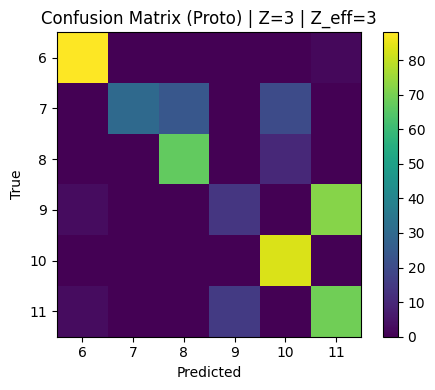


Overall acc (prototypes, Z=5 | Z_eff=5): 0.7560 (75.60%)
Per-label acc: {6: 0.8777777777777778, 7: 0.8378378378378378, 8: 0.922077922077922, 9: 0.19101123595505617, 10: 0.9879518072289156, 11: 0.7701149425287356}


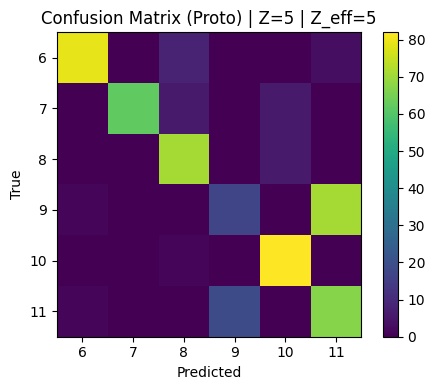


Overall acc (prototypes, Z=10 | Z_eff=10): 0.7540 (75.40%)
Per-label acc: {6: 0.9888888888888889, 7: 0.8918918918918919, 8: 0.8701298701298701, 9: 0.15730337078651685, 10: 0.9518072289156626, 11: 0.7126436781609196}


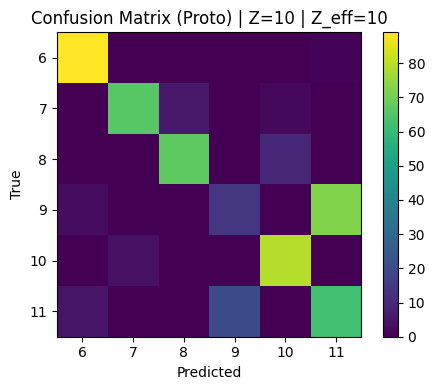


Overall acc (prototypes, Z=15 | Z_eff=15): 0.7720 (77.20%)
Per-label acc: {6: 0.9777777777777777, 7: 0.9324324324324325, 8: 0.922077922077922, 9: 0.11235955056179775, 10: 0.9156626506024096, 11: 0.8275862068965517}


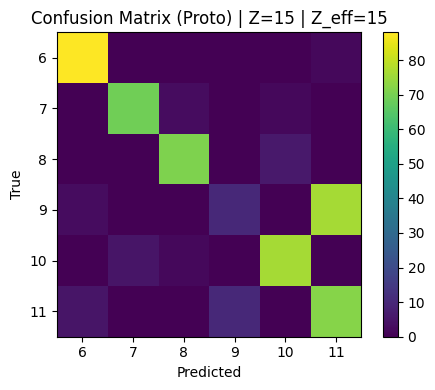


Overall acc (prototypes, Z=20 | Z_eff=20): 0.7760 (77.60%)
Per-label acc: {6: 0.9777777777777777, 7: 0.918918918918919, 8: 0.8961038961038961, 9: 0.1348314606741573, 10: 0.9518072289156626, 11: 0.8275862068965517}


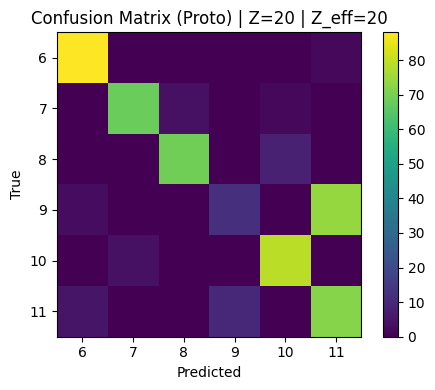


Overall acc (prototypes, Z=50 | Z_eff=50): 0.7580 (75.80%)
Per-label acc: {6: 0.9555555555555556, 7: 0.8243243243243243, 8: 0.8831168831168831, 9: 0.1348314606741573, 10: 0.9879518072289156, 11: 0.8045977011494253}


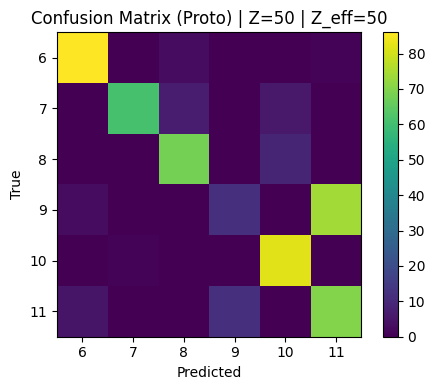


Overall acc (prototypes, Z=100 | Z_eff=None): 0.7580 (75.80%)
Per-label acc: {6: 0.9111111111111111, 7: 0.8108108108108109, 8: 0.922077922077922, 9: 0.14606741573033707, 10: 1.0, 11: 0.8045977011494253}


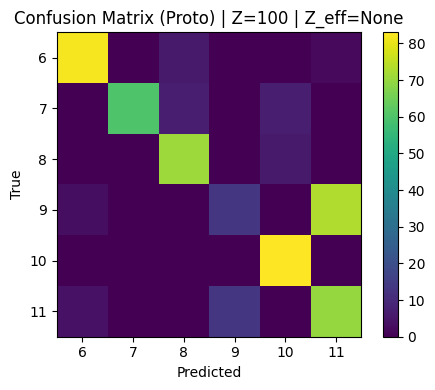

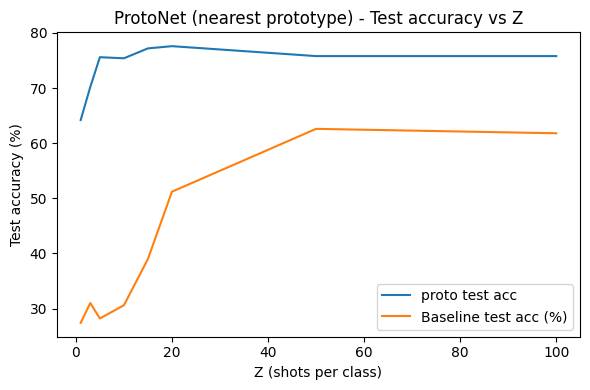

In [54]:
#test prototypes pour les mêmes Z que max_samples (baseline)

dataset_enroll = MyDataset(sample_path)# labels 6-11
dataset_test_fs = MyDataset(test_path)# labels 6-11

Z_list = []
acc_list = []

for Z in max_samples:

    # si Z trop grand on met None (= use all enroll samples per class)
    min_per_class = min([int((dataset_enroll.labels == k).sum().item()) for k in [6,7,8,9,10,11]])
    Z_eff = None if Z > min_per_class else Z

    prototypes = compute_prototypes(model_proto_loaded,dataset_enroll,labels=(6,7,8,9,10,11),n_shots=Z_eff,device=device,seed=0)

    acc, per_label_acc, cm, display_labels = evaluate_with_prototypes(model_proto_loaded, dataset_test_fs, prototypes, device=device)

    Z_list.append(Z)
    acc_list.append(float(acc))

    print(f"\nOverall acc (prototypes, Z={Z} | Z_eff={Z_eff}): {acc:.4f} ({acc*100:.2f}%)")
    print("Per-label acc:", per_label_acc)

    plt.figure(figsize=(5,4))
    plt.imshow(cm, interpolation="nearest")
    plt.title(f"Confusion Matrix (Proto) | Z={Z} | Z_eff={Z_eff}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.colorbar()
    plt.xticks(range(len(display_labels)), display_labels)
    plt.yticks(range(len(display_labels)), display_labels)
    plt.tight_layout()
    plt.show()

# courbe acc test vs Z
plt.figure(figsize=(6,4))
plt.plot(Z_list, np.array(acc_list)*100,label='proto test acc')
plt.plot(max_samples, np.array(test_acc_list)*100, label='Baseline test acc (%)')
plt.xlabel("Z (shots per class)")
plt.ylabel("Test accuracy (%)")
plt.title("ProtoNet (nearest prototype) - Test accuracy vs Z")
plt.legend()
plt.tight_layout()
plt.show()


##### Commentaires : 
* On obtient des résultats bien meilleurs que la baseline, surtout dans le régime few-shot (petit Z), qui est la zone qui nous intéresse. 

* En revanche, on observe une forte variabilité, selon quels échantillons sont choisis pour construire les prototypes, la test accuracy varie.

* On quantifie cette aléatoire en répétant l’évaluation sur 100 seeds(ie 100 différent pack de sample tiré) : pour chaque Z, on calcule la moyenne et l’écart-type de la test accuracy. On trace ensuite une courbe récapitulative baseline vs proto (moyenne sur seeds) pour vérifier que le gain de perf n'était pas dû à un “bon tirage” de prototypes.






=== Z=1 | Z_eff=1 ===
test acc: mean=0.6591 std=0.0749 (min=0.4800, max=0.7860)

=== Z=3 | Z_eff=3 ===
test acc: mean=0.7259 std=0.0405 (min=0.6020, max=0.8140)

=== Z=5 | Z_eff=5 ===
test acc: mean=0.7415 std=0.0334 (min=0.6260, max=0.8000)

=== Z=10 | Z_eff=10 ===
test acc: mean=0.7499 std=0.0221 (min=0.6840, max=0.8000)

=== Z=15 | Z_eff=15 ===
test acc: mean=0.7519 std=0.0214 (min=0.6640, max=0.7860)

=== Z=20 | Z_eff=20 ===
test acc: mean=0.7531 std=0.0172 (min=0.7100, max=0.7880)

=== Z=50 | Z_eff=50 ===
test acc: mean=0.7585 std=0.0116 (min=0.7240, max=0.7860)

=== Z=100 | Z_eff=None ===
test acc: mean=0.7580 std=0.0000 (min=0.7580, max=0.7580)


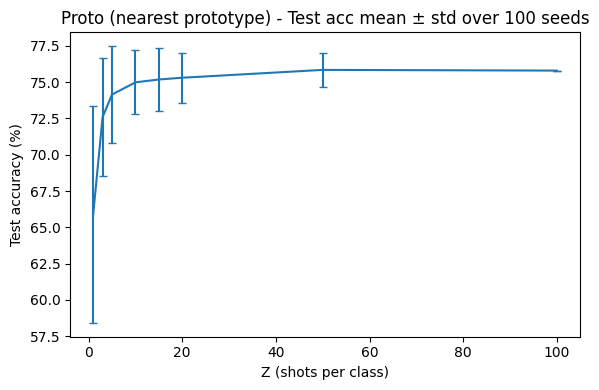

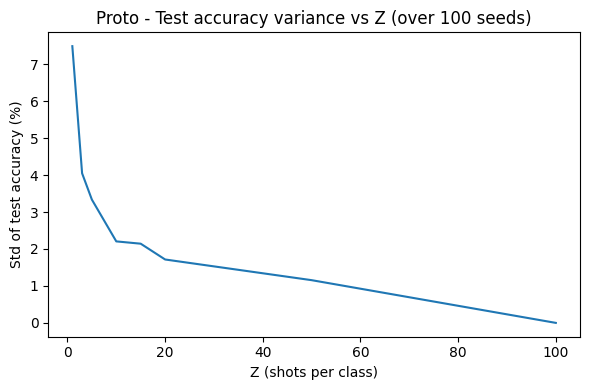

In [47]:
n_seeds = 100
labels_novel = (6, 7, 8, 9, 10, 11)

dataset_enroll = MyDataset(sample_path)   # labels 6-11
dataset_test_fs = MyDataset(test_path)    # labels 6-11

# store accs: dict Z c'est la list of acc over seeds
acc_by_Z = {Z: [] for Z in max_samples}

# precompute min per class 
# à partir de nshot >= min per_class on prend tout le dataset pour construire le prototype
min_per_class = min([int((dataset_enroll.labels == k).sum().item()) for k in labels_novel])

for Z in max_samples:
    Z_eff = None if Z > min_per_class else Z
    print(f"\n=== Z={Z} | Z_eff={Z_eff} ===")

    for seed in range(n_seeds):
        prototypes = compute_prototypes(
            model_proto_loaded,
            dataset_enroll,
            labels=labels_novel,
            n_shots=Z_eff,
            device=device,
            seed=seed,
        )

        acc, _, _, _ = evaluate_with_prototypes(
            model_proto_loaded,
            dataset_test_fs,
            prototypes,
            device=device
        )

        acc_by_Z[Z].append(float(acc))

    arr = np.array(acc_by_Z[Z])
    print(f"test acc: mean={arr.mean():.4f} std={arr.std():.4f} "
          f"(min={arr.min():.4f}, max={arr.max():.4f})")

# plots: mean ± std + std alone
Z_list = np.array(max_samples)
means = np.array([np.mean(acc_by_Z[Z]) for Z in max_samples])
stds  = np.array([np.std(acc_by_Z[Z])  for Z in max_samples])

plt.figure(figsize=(6,4))
plt.errorbar(Z_list, means*100, yerr=stds*100, capsize=3)
plt.xlabel("Z (shots per class)")
plt.ylabel("Test accuracy (%)")
plt.title(f"Proto (nearest prototype) - Test acc mean ± std over {n_seeds} seeds")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(Z_list, stds*100)
plt.xlabel("Z (shots per class)")
plt.ylabel("Std of test accuracy (%)")
plt.title(f"Proto - Test accuracy variance vs Z (over {n_seeds} seeds)")
plt.tight_layout()
plt.show()


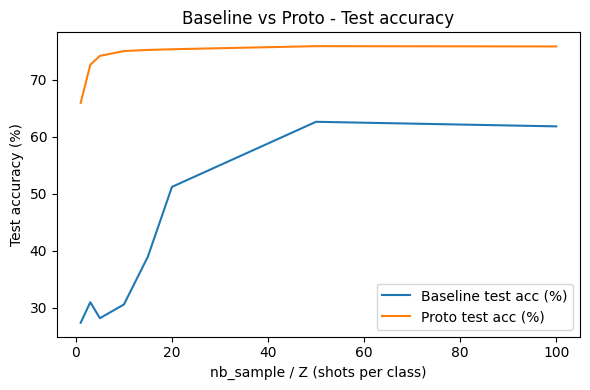

In [48]:

plt.figure(figsize=(6,4))
plt.plot(max_samples, np.array(test_acc_list)*100, label='Baseline test acc (%)')
plt.plot(max_samples, np.array(means)*100, label='Proto test acc (%)')
plt.xlabel('nb_sample / Z (shots per class)')
plt.ylabel('Test accuracy (%)')
plt.title('Baseline vs Proto - Test accuracy')
plt.legend()
plt.tight_layout()
plt.show()


##### Commentaires resultats moyens obtenus 
* Même en moyennant sur beaucoup de seeds, la méthode prototypical reste nettement au-dessus de la baseline. On observe cependant une assez forte variance pour de petit nombre de samples utilisés.


#### Protoype par label par snr
* Comme le SNR est disponible au test et influence fortement l’embedding, on teste une variante où l’on calcule un prototype par (label, SNR) et on compare chaque exemple test uniquement aux prototypes du même SNR.

    

In [49]:
@torch.no_grad()
def compute_prototypes_by_snr(
    model,
    enroll_dataset,
    labels=(6,7,8,9,10,11),
    snr_values=None,          # None => auto from enroll
    n_shots=None,             # shots PER (label, snr)
    batch_size=256,
    device="cuda",
    seed=0,
):
    model.eval()
    dl = DataLoader(enroll_dataset, batch_size=batch_size, shuffle=False)

    if snr_values is None:
        snr_values = torch.unique(enroll_dataset.snr).tolist()

    # dict[(k,s)] -> sum/count
    sums = {(k,s): None for k in labels for s in snr_values}
    counts = {(k,s): 0 for k in labels for s in snr_values}

    # preselect indices per (label,snr) if n_shots is not None
    shot_indices = None
    if n_shots is not None:
        g = torch.Generator().manual_seed(int(seed))
        shot_indices = {}
        for k in labels:
            for s in snr_values:
                idx = torch.where((enroll_dataset.labels == k) & (enroll_dataset.snr == s))[0]
                if idx.numel() == 0:
                    continue
                if idx.numel() < n_shots:
                    # pas assez -> on prendra tout (pas d'erreur, pour éviter de casser)
                    shot_indices[(k,s)] = set(idx.tolist())
                else:
                    sel = idx[torch.randperm(idx.numel(), generator=g)[:n_shots]]
                    shot_indices[(k,s)] = set(sel.tolist())

    global_idx = 0
    for x, snr, y in dl:
        snr = snr.to(device)
        b = x.shape[0]
        x = x.float().to(device)
        snr_b = snr.float().to(device).unsqueeze(1)
        y = y.long().to(device)

        z, _ = model(x, snr_b)  # (B,d)

        for k in labels:
            mk = (y == k)
            if not mk.any():
                continue

            # snr values in this batch for this class
            snr_k = snr[mk]  # CPU tensor (from dataset)
            z_k_all = z[mk]

            for s in snr_values:
                ms = (snr_k == s)
                if not ms.any():
                    continue

                z_ks = z_k_all[ms]

                # apply shots filtering if requested
                if shot_indices is not None:
                    idxs = torch.arange(global_idx, global_idx + b, device=device)[mk][ms]
                    keep = torch.tensor([i.item() in shot_indices[(k,s)] for i in idxs],
                                        device=device, dtype=torch.bool)
                    z_ks = z_ks[keep] if keep.any() else None

                if z_ks is not None and z_ks.numel() > 0:
                    key = (k, s)
                    sums[key] = z_ks.sum(dim=0) if sums[key] is None else (sums[key] + z_ks.sum(dim=0))
                    counts[key] += z_ks.shape[0]

        global_idx += b

    prototypes = {}
    for k in labels:
        for s in snr_values:
            key = (k, s)
            if counts[key] > 0:
                prototypes[key] = (sums[key] / counts[key]).detach().cpu()

    return prototypes, snr_values


In [50]:
@torch.no_grad()
def evaluate_with_prototypes_by_snr(
    model,
    test_dataset,
    prototypes_by_snr,    # dict[(label, snr)] -> proto
    snr_values,
    labels=(6,7,8,9,10,11),
    batch_size=256,
    device="cuda",
):
    model.eval()
    dl = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # confusion matrix sur labels 6..11
    C = len(labels)
    lab2i = {lab:i for i,lab in enumerate(labels)}
    cm = torch.zeros(C, C, dtype=torch.long)

    correct, total = 0, 0

    for x, snr, y in dl:
        x = x.float().to(device)
        snr_b = snr.float().to(device).unsqueeze(1)
        y = y.long().to(device)

        z, _ = model(x, snr_b)  # (B,d)

        # pour chaque sample, on compare seulement aux prototypes du snr correspondant
        preds = []
        for i in range(z.shape[0]):
            s = int(snr[i].item())
            # build proto matrix for this s
            proto_list = []
            lab_list = []
            for k in labels:
                key = (k, s)
                if key in prototypes_by_snr:
                    proto_list.append(prototypes_by_snr[key])
                    lab_list.append(k)
            if len(proto_list) == 0:
                # fallback: si aucun proto pour ce snr, on retombe sur "tous snr"
                # (ou tu peux raise)
                proto_list = [prototypes_by_snr[(k, ss)]
                              for (k, ss) in prototypes_by_snr.keys() if k in labels]
                lab_list = [k for (k, ss) in prototypes_by_snr.keys() if k in labels]

            proto_mat = torch.stack(proto_list, dim=0).to(device)  # (C',d)
            labs_t = torch.tensor(lab_list, device=device, dtype=torch.long)

            dists = torch.cdist(z[i:i+1], proto_mat) ** 2          # (1,C')
            pred = labs_t[dists.argmin(dim=1)].item()
            preds.append(pred)

        pred = torch.tensor(preds, device=device, dtype=torch.long)

        total += y.numel()
        correct += (pred == y).sum().item()

        # cm CPU
        y_cpu = y.detach().cpu().tolist()
        p_cpu = pred.detach().cpu().tolist()
        for yt, yp in zip(y_cpu, p_cpu):
            cm[lab2i[yt], lab2i[yp]] += 1

    acc = correct / total
    return acc, cm.numpy(), labels


Z=1 | acc prototype-by-snr = 0.6960


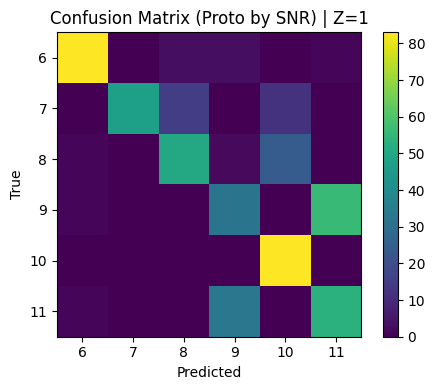

Z=3 | acc prototype-by-snr = 0.7740


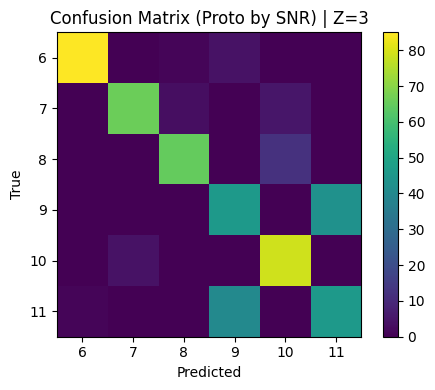

Z=5 | acc prototype-by-snr = 0.7660


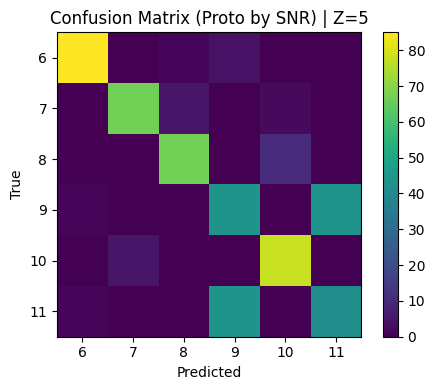

Z=10 | acc prototype-by-snr = 0.7860


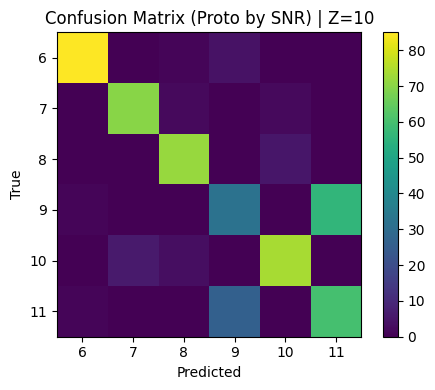

Z=15 | acc prototype-by-snr = 0.7700


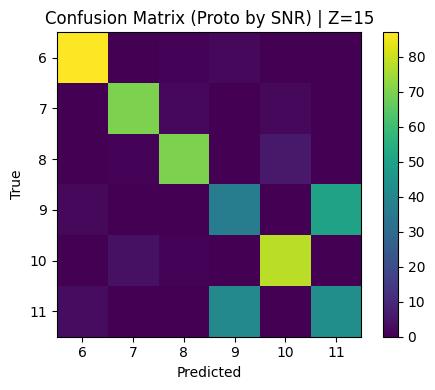

Z=20 | acc prototype-by-snr = 0.7680


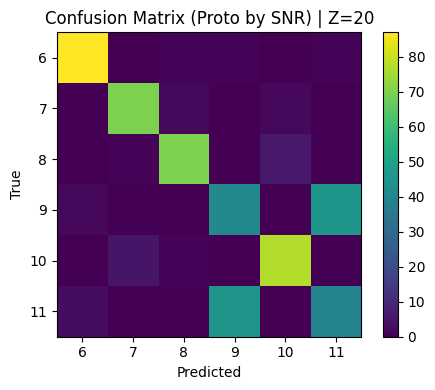

Z=50 | acc prototype-by-snr = 0.7700


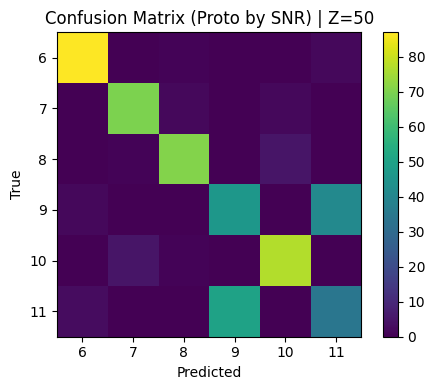

Z=100 | acc prototype-by-snr = 0.7700


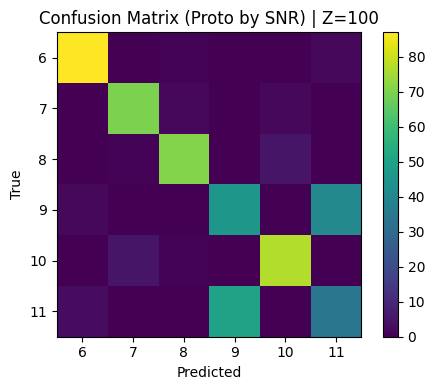

In [51]:
for Z in max_samples:
    prototypes_snr, snr_vals = compute_prototypes_by_snr(
        model_proto_loaded,
        dataset_enroll,
        labels=(6,7,8,9,10,11),
        n_shots=Z,          # shots PER (label,snr)
        device=device,
        seed=3,
    )

    acc, cm, display_labels = evaluate_with_prototypes_by_snr(
        model_proto_loaded,
        dataset_test_fs,
        prototypes_snr,
        snr_vals,
        labels=(6,7,8,9,10,11),
        device=device
    )

    print(f"Z={Z} | acc prototype-by-snr = {acc:.4f}")
    plt.figure(figsize=(5,4))
    plt.imshow(cm, interpolation="nearest")
    plt.title(f"Confusion Matrix (Proto by SNR) | Z={Z}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.colorbar()
    plt.xticks(range(len(display_labels)), display_labels)
    plt.yticks(range(len(display_labels)), display_labels)
    plt.tight_layout()
    plt.show()


##### Commentaires résultats :
Les performances sont du même ordre, parfois légèrement meilleures. On refait la même expérience “moyenne ± écart-type sur seeds” pour vérifier si cette variante réduit la variance et quand elle devient bénéfique.


min_per_class in enroll: 66

==================== Z=1 ====================
[classic]  Z_eff=1 | mean=0.6591 std=0.0749 (min=0.4800, max=0.7860)
[snr]      Z<3 -> classic | mean=0.6591 std=0.0749 (min=0.4800, max=0.7860)

==================== Z=3 ====================
[classic]  Z_eff=3 | mean=0.7259 std=0.0405 (min=0.6020, max=0.8140)
[snr]      Z_snr=1 (per snr) | mean=0.6792 std=0.0667 (min=0.4800, max=0.7880)

==================== Z=5 ====================
[classic]  Z_eff=5 | mean=0.7415 std=0.0334 (min=0.6260, max=0.8000)
[snr]      Z_snr=1 (per snr) | mean=0.6792 std=0.0667 (min=0.4800, max=0.7880)

==================== Z=10 ====================
[classic]  Z_eff=10 | mean=0.7499 std=0.0221 (min=0.6840, max=0.8000)
[snr]      Z_snr=3 (per snr) | mean=0.7477 std=0.0304 (min=0.6400, max=0.7940)

==================== Z=15 ====================
[classic]  Z_eff=15 | mean=0.7519 std=0.0214 (min=0.6640, max=0.7860)
[snr]      Z_snr=5 (per snr) | mean=0.7607 std=0.0219 (min=0.6720, max=0.80

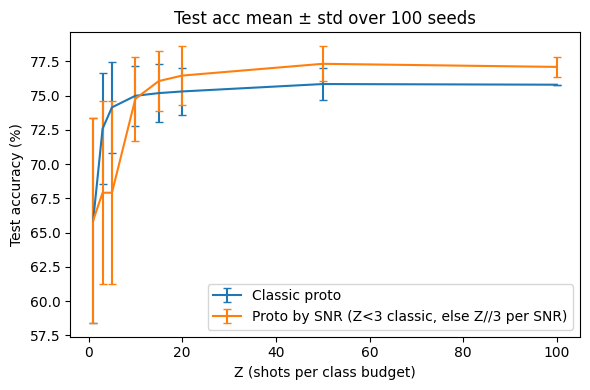

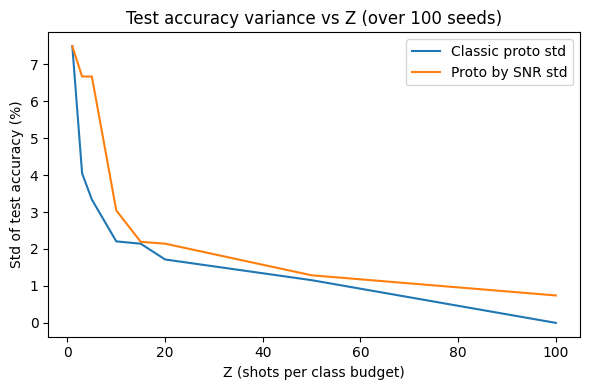

In [ ]:
# Variance of test accuracy vs Z over many seeds
#   - classic prototypes
#   - prototypes conditioned on SNR with budget split: Z//3 per snr (if Z>=3)

n_seeds = 100
labels_novel = (6, 7, 8, 9, 10, 11)

dataset_enroll = MyDataset(sample_path)   # labels 6-11
dataset_test_fs = MyDataset(test_path)    # labels 6-11

# storage: dict Z -> list(acc over seeds)
acc_by_Z_classic = {Z: [] for Z in max_samples}
acc_by_Z_snr     = {Z: [] for Z in max_samples}

# enroll availability
min_per_class = min([int((dataset_enroll.labels == k).sum().item()) for k in labels_novel])
print("min_per_class in enroll:", min_per_class)

# if you want to force exactly 3 snr values (e.g., [10,20,30]) uncomment:
# snr_vals_fixed = [10, 20, 30]
snr_vals_fixed = None  # auto from enroll

for Z in max_samples:
    print(f"\n==================== Z={Z} ====================")

    # ---------- (A) Classic prototypes: n_shots = Z (or None if too large) ----------
    Z_eff = None if Z > min_per_class else Z

    for seed in range(n_seeds):
        prototypes = compute_prototypes(
            model_proto_loaded,
            dataset_enroll,
            labels=labels_novel,
            n_shots=Z_eff,
            device=device,
            seed=seed,
        )
        acc, _, _, _ = evaluate_with_prototypes(
            model_proto_loaded,
            dataset_test_fs,
            prototypes,
            device=device
        )
        acc_by_Z_classic[Z].append(float(acc))

    arr = np.array(acc_by_Z_classic[Z])
    print(f"[classic]  Z_eff={Z_eff} | mean={arr.mean():.4f} std={arr.std():.4f} (min={arr.min():.4f}, max={arr.max():.4f})")

    # ---------- (B) SNR-conditioned prototypes ----------
    # rule you asked:
    # - if Z < 3: behave like classic (same randomness as before)
    # - else: Z_snr = Z//3 shots PER (label, snr), so total per class ≈ 3*(Z//3) <= Z
    if Z < 3:
        # identical to classic for comparability
        for seed in range(n_seeds):
            prototypes = compute_prototypes(
                model_proto_loaded,
                dataset_enroll,
                labels=labels_novel,
                n_shots=Z_eff,
                device=device,
                seed=seed,
            )
            acc, _, _, _ = evaluate_with_prototypes(
                model_proto_loaded,
                dataset_test_fs,
                prototypes,
                device=device
            )
            acc_by_Z_snr[Z].append(float(acc))

        arr = np.array(acc_by_Z_snr[Z])
        print(f"[snr]      Z<3 -> classic | mean={arr.mean():.4f} std={arr.std():.4f} (min={arr.min():.4f}, max={arr.max():.4f})")

    else:
        Z_snr = max(1, Z // 3)

        for seed in range(n_seeds):
            prototypes_snr, snr_vals = compute_prototypes_by_snr(
                model_proto_loaded,
                dataset_enroll,
                labels=labels_novel,
                snr_values=snr_vals_fixed,
                n_shots=Z_snr,     # shots PER (label, snr)
                device=device,
                seed=seed,
            )

            acc, _, _ = evaluate_with_prototypes_by_snr(
                model_proto_loaded,
                dataset_test_fs,
                prototypes_snr,
                snr_vals,
                labels=labels_novel,
                device=device
            )

            acc_by_Z_snr[Z].append(float(acc))

        arr = np.array(acc_by_Z_snr[Z])
        print(f"[snr]      Z_snr={Z_snr} (per snr) | mean={arr.mean():.4f} std={arr.std():.4f} (min={arr.min():.4f}, max={arr.max():.4f})")


# Plots: mean ± std (classic and snr) + std alone
Z_list = np.array(max_samples)

means_classic = np.array([np.mean(acc_by_Z_classic[Z]) for Z in max_samples])
stds_classic  = np.array([np.std(acc_by_Z_classic[Z])  for Z in max_samples])

means_snr = np.array([np.mean(acc_by_Z_snr[Z]) for Z in max_samples])
stds_snr  = np.array([np.std(acc_by_Z_snr[Z])  for Z in max_samples])

plt.figure(figsize=(6,4))
plt.errorbar(Z_list, means_classic*100, yerr=stds_classic*100, capsize=3, label="Classic proto")
plt.errorbar(Z_list, means_snr*100,     yerr=stds_snr*100,     capsize=3, label="Proto by SNR (Z<3 classic, else Z//3 per SNR)")
plt.xlabel("Z (shots per class budget)")
plt.ylabel("Test accuracy (%)")
plt.title(f"Test acc mean ± std over {n_seeds} seeds")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(Z_list, stds_classic*100, label="Classic proto std")
plt.plot(Z_list, stds_snr*100,     label="Proto by SNR std")
plt.xlabel("Z (shots per class budget)")
plt.ylabel("Std of test accuracy (%)")
plt.title(f"Test accuracy variance vs Z (over {n_seeds} seeds)")
plt.legend()
plt.tight_layout()
plt.show()


##### Commentaires :
Au final, on voit que la version SNR-aware devient intéressante quand on a suffisamment de shots (typiquement Z >10), alors que pour très petit Z elle peut être moins stable (moins d’échantillons par SNR).


#### Fine-tuning avant de calculer les prototypes
On teste une dernière méthode : 
Avant de construire les prototypes, on fait un petit fine-tuning épisodique de l’encodeur sur les Z données labellisées disponibles (classes 6–11), puis on recalcule les prototypes et on réévalue. On garde la même logique de seed pour que la comparaison soit propre.
L’idée est de mieux aligner l’espace d’embedding sur les nouvelles classes avec très peu d’updates, sans jamais toucher au dataset test (pas de leakage).


min_per_class in enroll: 66

=== Z=1 | Z_eff=1 ===
finetune+proto test acc: mean=0.5929 std=0.0664 (min=0.4260, max=0.7280)

=== Z=3 | Z_eff=3 ===
finetune+proto test acc: mean=0.6831 std=0.0526 (min=0.5220, max=0.7660)

=== Z=5 | Z_eff=5 ===
finetune+proto test acc: mean=0.7204 std=0.0417 (min=0.5920, max=0.7880)

=== Z=10 | Z_eff=10 ===
finetune+proto test acc: mean=0.7504 std=0.0323 (min=0.6320, max=0.8140)

=== Z=15 | Z_eff=15 ===
finetune+proto test acc: mean=0.7671 std=0.0273 (min=0.7020, max=0.8120)

=== Z=20 | Z_eff=20 ===
finetune+proto test acc: mean=0.7754 std=0.0182 (min=0.7240, max=0.8060)

=== Z=50 | Z_eff=50 ===
finetune+proto test acc: mean=0.7962 std=0.0081 (min=0.7740, max=0.8120)

=== Z=100 | Z_eff=None ===
finetune+proto test acc: mean=0.7980 std=0.0042 (min=0.7880, max=0.8060)


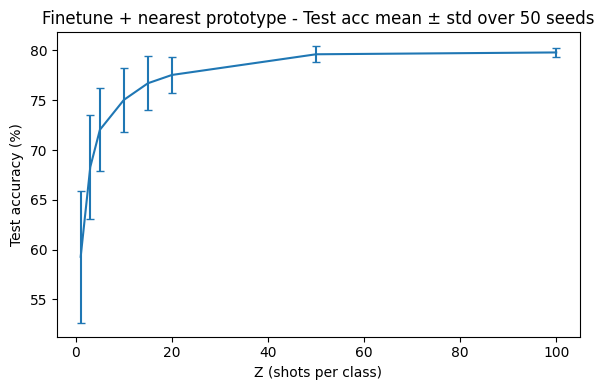

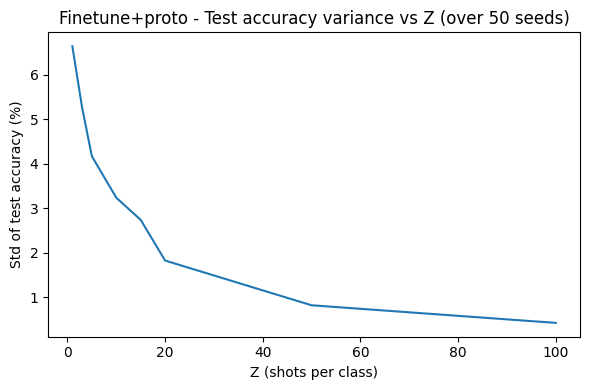


[seed=0] Overall acc (finetune+proto) | Z=1 | Z_eff=1: 0.6000 (60.00%)


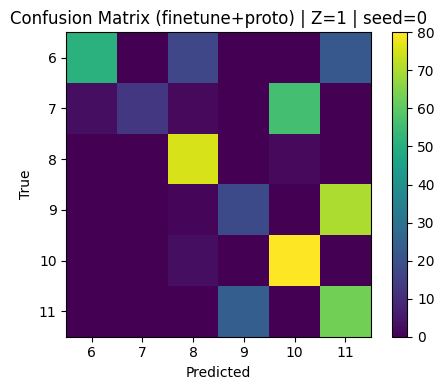


[seed=0] Overall acc (finetune+proto) | Z=3 | Z_eff=3: 0.6480 (64.80%)


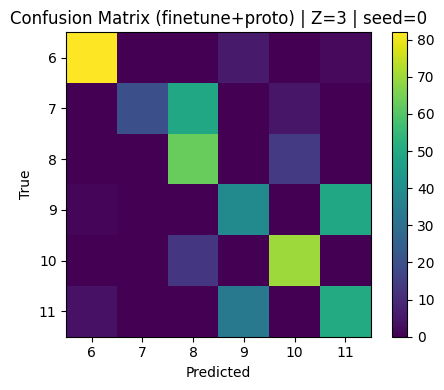


[seed=0] Overall acc (finetune+proto) | Z=5 | Z_eff=5: 0.7380 (73.80%)


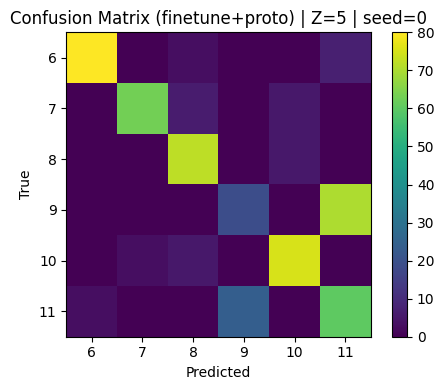


[seed=0] Overall acc (finetune+proto) | Z=10 | Z_eff=10: 0.7440 (74.40%)


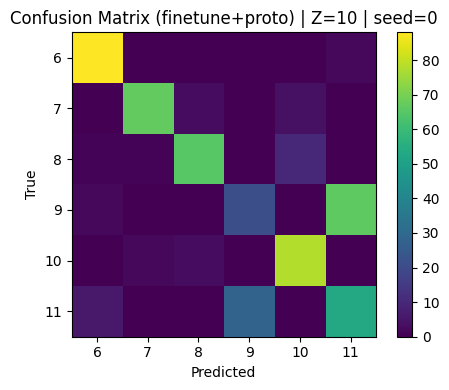


[seed=0] Overall acc (finetune+proto) | Z=15 | Z_eff=15: 0.7740 (77.40%)


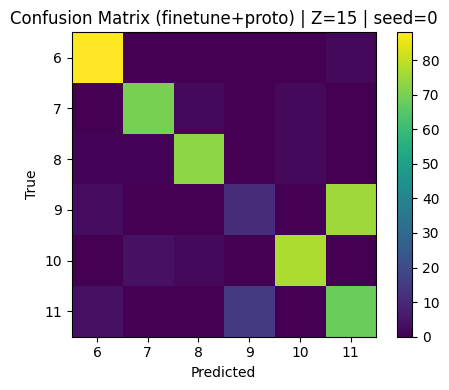


[seed=0] Overall acc (finetune+proto) | Z=20 | Z_eff=20: 0.8000 (80.00%)


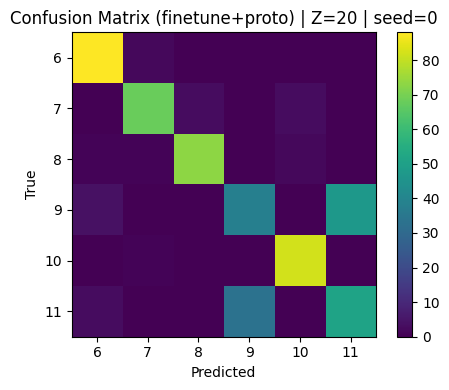


[seed=0] Overall acc (finetune+proto) | Z=50 | Z_eff=50: 0.7980 (79.80%)


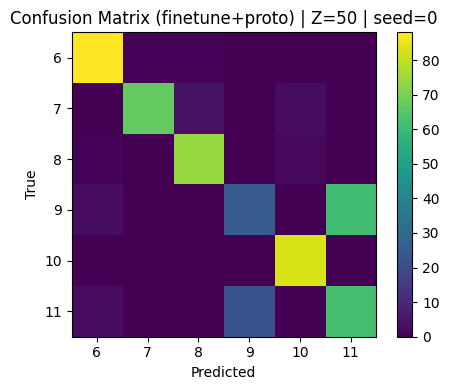


[seed=0] Overall acc (finetune+proto) | Z=100 | Z_eff=None: 0.7920 (79.20%)


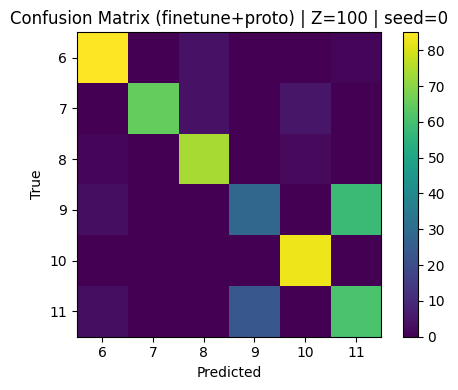

In [56]:
# Finetune + prototypes : moyenne (et std) sur 50 seeds

labels_novel = (6, 7, 8, 9, 10, 11)

dataset_enroll = MyDataset(sample_path)   # labels 6..11
dataset_test_fs = MyDataset(test_path)    # labels 6..11

# finetune hyperparams (petit)
ft_steps = 80
ft_lr = 1e-4
n_seeds = 50


min_per_class = min([int((dataset_enroll.labels == k).sum().item()) for k in labels_novel])

acc_by_Z_ft = {Z: [] for Z in max_samples}

for Z in max_samples:

    # Z_eff (None = use all)
    Z_eff = None if Z > min_per_class else Z
    print(f"\n=== Z={Z} | Z_eff={Z_eff} ===")

    for seed in range(n_seeds):

        # reload base encoder weights (fresh each seed)
        model_adapt = Reseau(mult=2).to(device)
        model_adapt.load_state_dict(torch.load(os.path.join(WEIGHTS_DIR_PROTO, model_pth_name), map_location=device))
        model_adapt.train()

        # freeze classifier head 
        for p in model_adapt.classifier.parameters():
            p.requires_grad = False

        optimizer_ft = torch.optim.Adam(
            [p for p in model_adapt.parameters() if p.requires_grad],
            lr=ft_lr,
            amsgrad=True
        )

        # IMPORTANT: meme seed logic as compute_prototypes
        D_k_novel = {}
        g = torch.Generator().manual_seed(int(seed))

        for i, lab in enumerate(labels_novel):
            idx_k = torch.where(dataset_enroll.labels == lab)[0]
            if idx_k.numel() == 0:
                raise ValueError(f"No enroll sample for label {lab}")

            if Z_eff is None:
                sel = idx_k
            else:
                sel = idx_k[torch.randperm(idx_k.numel(), generator=g)[:Z_eff]]

            D_k_novel[i] = (dataset_enroll.signals[sel], dataset_enroll.snr[sel], dataset_enroll.labels[sel])

        # choose episodic Ns/Nq for finetune depending on Z
        if Z_eff is None:
            N_s_ft, N_q_ft = 5, 15
        else:
            N_s_ft = max(1, min(5, Z_eff - 1))
            N_q_ft = max(1, min(15, Z_eff - N_s_ft))

        N_c_ft = 6  # use all novel classes each episode

        # small episodic finetuning on few-shot data (NO test usage)
        for t in range(ft_steps):
            optimizer_ft.zero_grad(set_to_none=True)
            loss_ft, acc_ft = prototypical_loss(model_adapt, D_k_novel, N_s_ft, N_q_ft, N_c_ft, device)
            loss_ft.backward()
            optimizer_ft.step()

        # compute prototypes (same Z shots logic, same seed for comparability)
        model_adapt.eval()
        prototypes = compute_prototypes(
            model_adapt,
            dataset_enroll,
            labels=labels_novel,
            n_shots=Z_eff,
            device=device,
            seed=seed
        )

        # eval on test fewshot
        acc, per_label_acc, cm, display_labels = evaluate_with_prototypes(
            model_adapt, dataset_test_fs, prototypes, device=device
        )

        acc_by_Z_ft[Z].append(float(acc))

    arr = np.array(acc_by_Z_ft[Z])
    print(f"finetune+proto test acc: mean={arr.mean():.4f} std={arr.std():.4f} (min={arr.min():.4f}, max={arr.max():.4f})")

# ---- plots mean ± std + std alone
Z_list = np.array(max_samples)
means_ft = np.array([np.mean(acc_by_Z_ft[Z]) for Z in max_samples])
stds_ft  = np.array([np.std(acc_by_Z_ft[Z])  for Z in max_samples])

plt.figure(figsize=(6,4))
plt.errorbar(Z_list, means_ft*100, yerr=stds_ft*100, capsize=3)
plt.xlabel("Z (shots per class)")
plt.ylabel("Test accuracy (%)")
plt.title(f"Finetune + nearest prototype - Test acc mean ± std over {n_seeds} seeds")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(Z_list, stds_ft*100)
plt.xlabel("Z (shots per class)")
plt.ylabel("Std of test accuracy (%)")
plt.title(f"Finetune+proto - Test accuracy variance vs Z (over {n_seeds} seeds)")
plt.tight_layout()
plt.show()

#  on prend juste un seed "typique" (ex: seed=0) et on affiche cm pour chaque Z
seed_visu = 0
for Z in max_samples:
    Z_eff = None if Z > min_per_class else Z

    model_adapt = Reseau(mult=2).to(device)
    model_adapt.load_state_dict(torch.load(os.path.join(WEIGHTS_DIR_PROTO, model_pth_name), map_location=device))
    model_adapt.train()

    for p in model_adapt.classifier.parameters():
        p.requires_grad = False

    optimizer_ft = torch.optim.Adam(
        [p for p in model_adapt.parameters() if p.requires_grad],
        lr=ft_lr,
        amsgrad=True
    )

    D_k_novel = {}
    g = torch.Generator().manual_seed(int(seed_visu))
    for i, lab in enumerate(labels_novel):
        idx_k = torch.where(dataset_enroll.labels == lab)[0]
        sel = idx_k if Z_eff is None else idx_k[torch.randperm(idx_k.numel(), generator=g)[:Z_eff]]
        D_k_novel[i] = (dataset_enroll.signals[sel], dataset_enroll.snr[sel], dataset_enroll.labels[sel])

    if Z_eff is None:
        N_s_ft, N_q_ft = 5, 15
    else:
        N_s_ft = max(1, min(5, Z_eff - 1))
        N_q_ft = max(1, min(15, Z_eff - N_s_ft))
    N_c_ft = 6

    for t in range(ft_steps):
        optimizer_ft.zero_grad(set_to_none=True)
        loss_ft, acc_ft = prototypical_loss(model_adapt, D_k_novel, N_s_ft, N_q_ft, N_c_ft, device)
        loss_ft.backward()
        optimizer_ft.step()

    model_adapt.eval()
    prototypes = compute_prototypes(
        model_adapt,
        dataset_enroll,
        labels=labels_novel,
        n_shots=Z_eff,
        device=device,
        seed=seed_visu
    )

    acc, per_label_acc, cm, display_labels = evaluate_with_prototypes(
        model_adapt, dataset_test_fs, prototypes, device=device
    )

    print(f"\n[seed={seed_visu}] Overall acc (finetune+proto) | Z={Z} | Z_eff={Z_eff}: {acc:.4f} ({acc*100:.2f}%)")
    plt.figure(figsize=(5,4))
    plt.imshow(cm, interpolation="nearest")
    plt.title(f"Confusion Matrix (finetune+proto) | Z={Z} | seed={seed_visu}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.colorbar()
    plt.xticks(range(len(display_labels)), display_labels)
    plt.yticks(range(len(display_labels)), display_labels)
    plt.tight_layout()
    plt.show()


##### Commentaires finetuning method : 
- performances legérement supérieur aux deux autres méthodes lorsque n_shots > 10. On approche les 80% de moyenne en accuracy. 

### Commentaires finaux sur la méthode implémenté : 
- On voit que ces méthodes ont toutes les mêmes difficultés, en particulier pour distinguer les classes 9 et 11 (confusion récurrente sur les matrices). Nous avons essayé d'augmenter le nombre de paramètres sans changer fondamentalement l’architecture (on a juste augmenter `n_mult`) mais cela n’apportait pas de réel gain. Il faudrait tester d’autres architectures (ex. blocs conv plus profonds, résiduels, meilleure intégration du SNR, etc.).